<span style='font-size: 200%; font-weight: bold; color: #45AED6;'>Investigating the correlation between Elon Musk's tweets and the fluctuations in the cryptocurrency market and Crypto price forecasting</span>

### Part 2- Cryptocurrency Price Prediction using ARIMA and FB Prophet

#### Importing Libraries

In [1]:
# Below we are importing the essential libraries
# for accessing, manupulating and visualizing the data.

import pandas as pd
import numpy as np

# Prediction libraries
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA
import fbprophet as Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import scipy.stats as stats

# Stationarity Checking
from statsmodels.tsa.stattools import adfuller       ### Augmented Dickey Fuller

# Plotting Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
%matplotlib inline

# Plotting Styles and other defaults
sns.set_style("white")
sns.set(font_scale=1.5)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.rcParams['figure.figsize'] = (18, 8) # Setting the default figure size of plots
plt.rcParams['font.size'] = 15.0 # Setting the font size of labels in plots

pd.set_option("display.precision", 3) # Setting the Precision to 3 digits after decimal

import warnings
warnings.filterwarnings("ignore")

# Section 1: Loading and Pre-processing Datasets

## Section 1.1: Loading  Cryptocurrency Datasets

In [2]:
# Bitcoin data
bitcoin = pd.read_csv("BTC-USD.csv", index_col= 'Date')

# Dogecoin data
dogecoin = pd.read_csv("DOGE-USD.csv", index_col= 'Date')

# Shiba-Inu Coin data
shibcoin = pd.read_csv("SHIB-USD.csv", index_col= 'Date')

## Section 1.2: Data Pre-processing

### Section 1.2.1 Cryptocurrency Data Pre-processing
Date is to be in Date-time format inorder to perform a time series study. In the current dataset the date is stated as an object which is to be converted by parsing through the read-csv command.

In [3]:
# Converting Date to Date-Time Format
bitcoin.index = pd.to_datetime(bitcoin.index, format='%d-%m-%Y')
dogecoin.index = pd.to_datetime(dogecoin.index, format='%Y-%m-%d')
shibcoin.index = pd.to_datetime(shibcoin.index, format='%Y-%m-%d')

#### Selecting Parameters

In [4]:
bitcoin = bitcoin[["Adj Close", "Volume"]]
dogecoin = dogecoin[["Adj Close", "Volume"]]
shibcoin = shibcoin[["Adj Close", "Volume"]]

The historical trading data of the 3 cryptocurrencies in consideration is obtained from yahoo finance. It contains some missing values. This will create problems in our analysis and visualization so we are going to remove these missing values from the datasets.

In [5]:
print (f'The missing values in Bitcoin data is \n {bitcoin.isna().sum()}', '\n\n'
      f'The missing values in Dogecoin data is \n {dogecoin.isna().sum()}', '\n\n'
      f'The missing values in Shiba-Inu coin data is \n {shibcoin.isna().sum()}')

The missing values in Bitcoin data is 
 Adj Close    4
Volume       4
dtype: int64 

The missing values in Dogecoin data is 
 Adj Close    4
Volume       4
dtype: int64 

The missing values in Shiba-Inu coin data is 
 Adj Close    230
Volume       230
dtype: int64


In [6]:
# Dropping NAN values from cryptocurrency datasets
bitcoin.dropna(axis=0, inplace=True)
dogecoin.dropna(axis=0, inplace=True)
shibcoin.dropna(axis=0, inplace=True)

In [7]:
# Lets check the shape of our pre-processed datasets
print(f'Bitcoin shape: {bitcoin.shape}', "\n" +
      f'Dogecoin shape: {dogecoin.shape}', "\n" +
      f'Shib-Inu Coin shape: {shibcoin.shape}')

Bitcoin shape: (2607, 2) 
Dogecoin shape: (2607, 2) 
Shib-Inu Coin shape: (236, 2)


# Section 2: Cryptocurrency Data Exploration

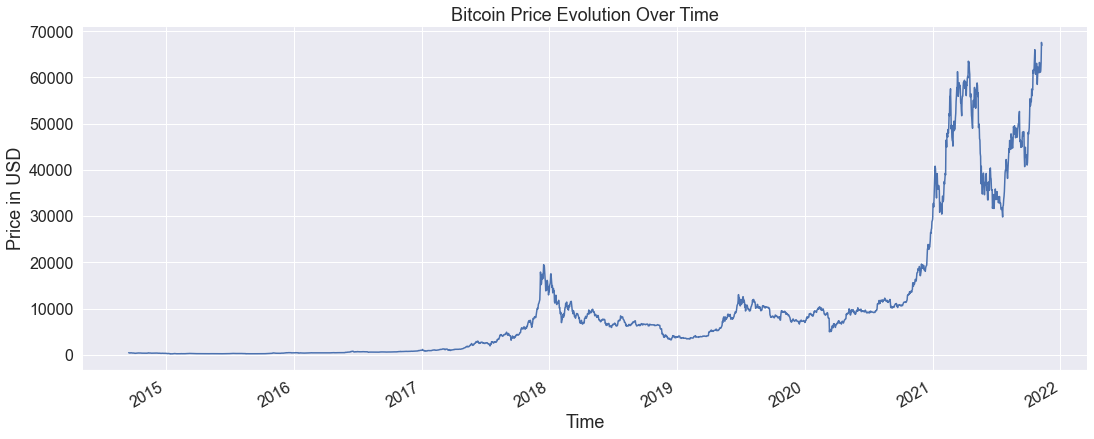

In [8]:
# Bitcoin Price Evolution
bitcoin['Adj Close'].plot(figsize=(18, 7), title='Bitcoin Price Evolution Over Time',
                          xlabel='Time', ylabel='Price in USD', legend=False);

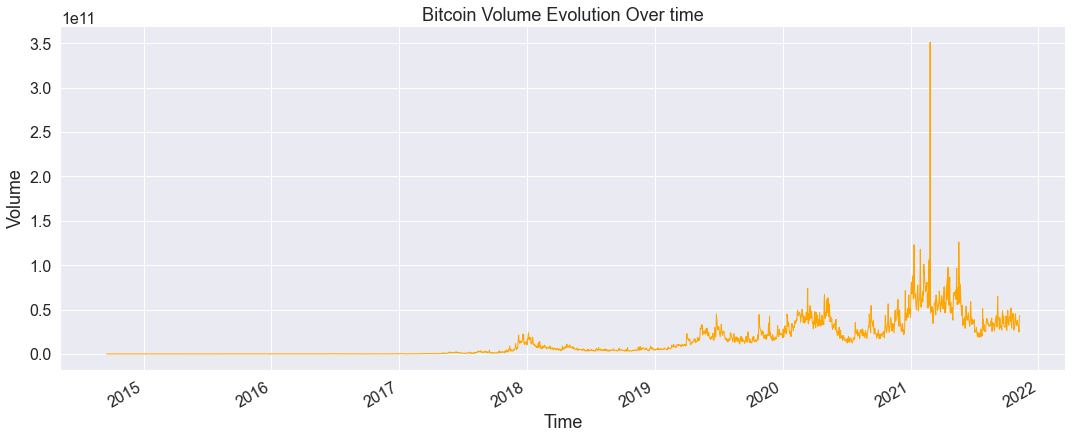

In [9]:
# Bitcoin Volume Evolution
bitcoin['Volume'].plot(figsize=(18, 7), title='Bitcoin Volume Evolution Over time',
                          xlabel='Time', ylabel='Volume', legend=False, lw=1, color='orange');

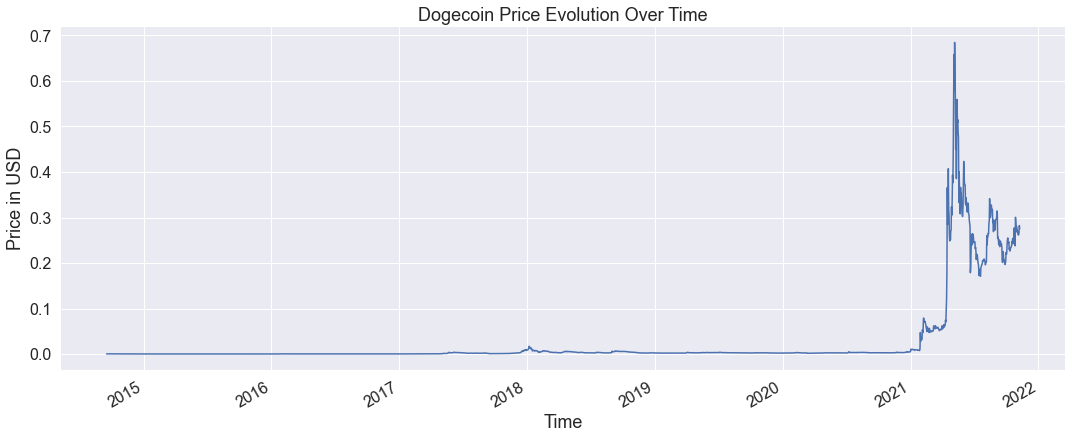

In [10]:
# Dogecoin Price Evolution
dogecoin['Adj Close'].plot(figsize=(18, 7), title='Dogecoin Price Evolution Over Time',
                          xlabel='Time', ylabel='Price in USD', legend=False);

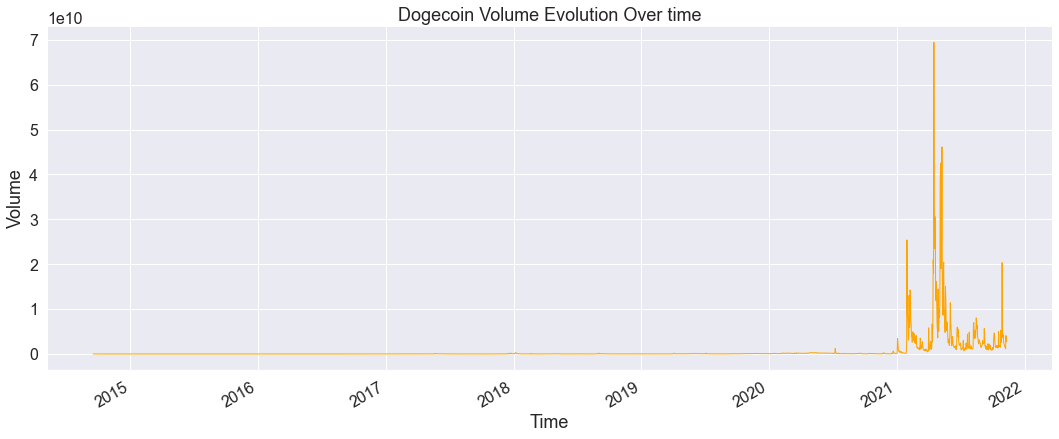

In [11]:
# Dogecoin Volume Evolution
dogecoin['Volume'].plot(figsize=(18, 7), title='Dogecoin Volume Evolution Over time',
                          xlabel='Time', ylabel='Volume', legend=False, lw=1, color='orange');

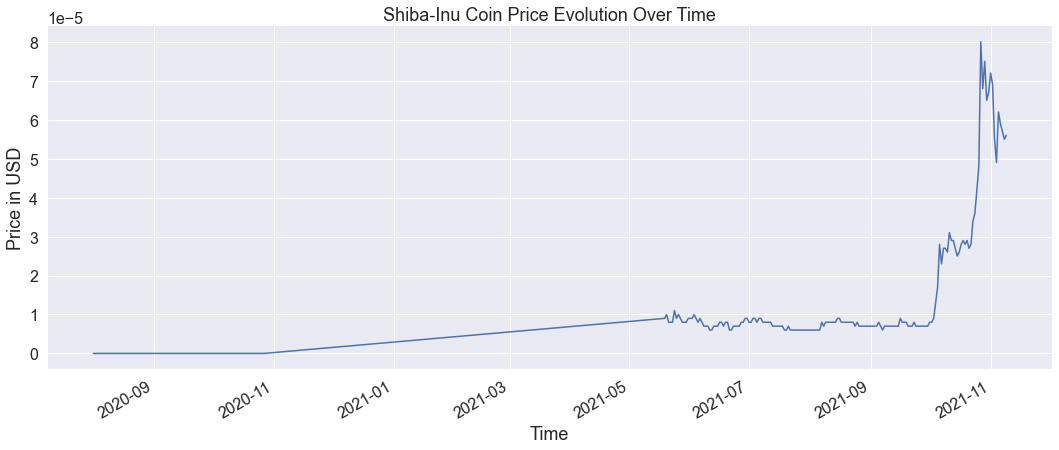

In [12]:
# Shib-Inu Coin Price Evolution
shibcoin['Adj Close'].plot(figsize=(18, 7), title='Shiba-Inu Coin Price Evolution Over Time',
                          xlabel='Time', ylabel='Price in USD', legend=False);

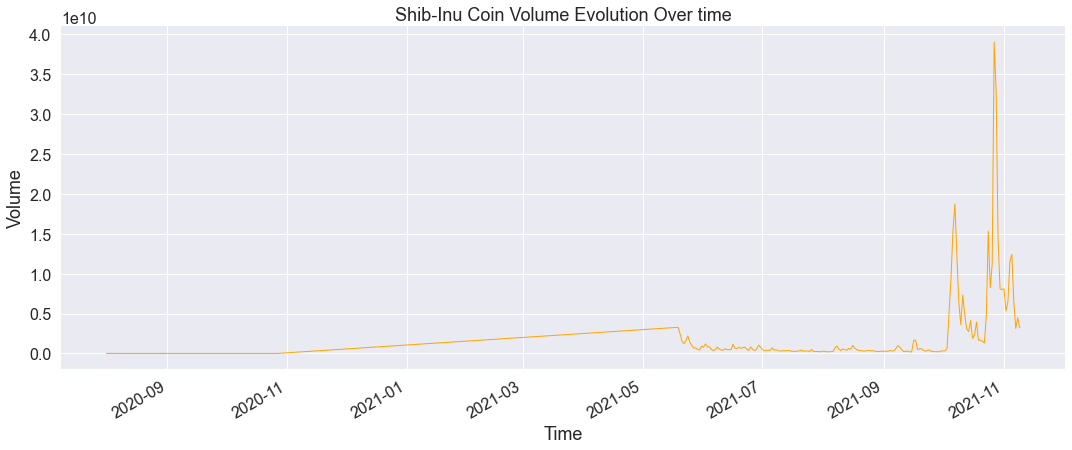

In [13]:
# Shiba-Inu Coin Volume Evolution
shibcoin['Volume'].plot(figsize=(18, 7), title='Shib-Inu Coin Volume Evolution Over time',
                          xlabel='Time', ylabel='Volume', legend=False, lw=1, color='orange');

# Section 3: Testing Stationarity
Our time series data can have a trend or not. It is of the utmost importance to determine how the series is behaving before applying any model to it.

Why is Stationarity Important?
For data to be stationary, the statistical properties of a system do not change over time. This does not mean that the values for each data point have to be the same, but the overall behavior of the data should remain constant.

If the data is non-stationary (meaning it has a trend), we need to remove it in order to proceed with the analysis.

In [14]:
bitcoin.dropna(axis=0, inplace=True)

bitcoin_price = bitcoin['Adj Close']
dogecoin_price = dogecoin['Adj Close']
shibcoin_price = shibcoin['Adj Close']

In [15]:
def test_for_stationary(input_data, data_name):
    '''Test stationarity of a Time Series dataset.'''
    
    # Perform Dickey-Fuller test:
    result = adfuller(input_data)
    print('Results of Augmented Dickey-Fuller Test on ' + data_name)
    print('ADF Stastistic: %f' % result[0])
    print('p-value: %f' % result[1])
    pvalue = result[1]

    for key, value in result[4].items():
        if result[0] > value:
            print("\nThe graph is non stationary! (It has a trend)")
            break
        else:
            print("\nThe graph is stationary! (It doesn't have a trend)")
            break

    print('\nCritical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
    
    # Determing rolling statistics
    r_mean = input_data.rolling(window=7, center=False).mean()
    r_std = input_data.rolling(window=7, center=False).std()

    # Plot rolling statistics:
    given = plt.plot(input_data, color='blue', label='Original')
    rolling_mean = plt.plot(r_mean, color='red', label='Rolling Mean')
    rolling_std = plt.plot(r_std, color='green', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of ' + data_name)
    plt.show(block=False)

Results of Augmented Dickey-Fuller Test on Bitcoin Data
ADF Stastistic: 1.045287
p-value: 0.994722

The graph is non stationary! (It has a trend)

Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


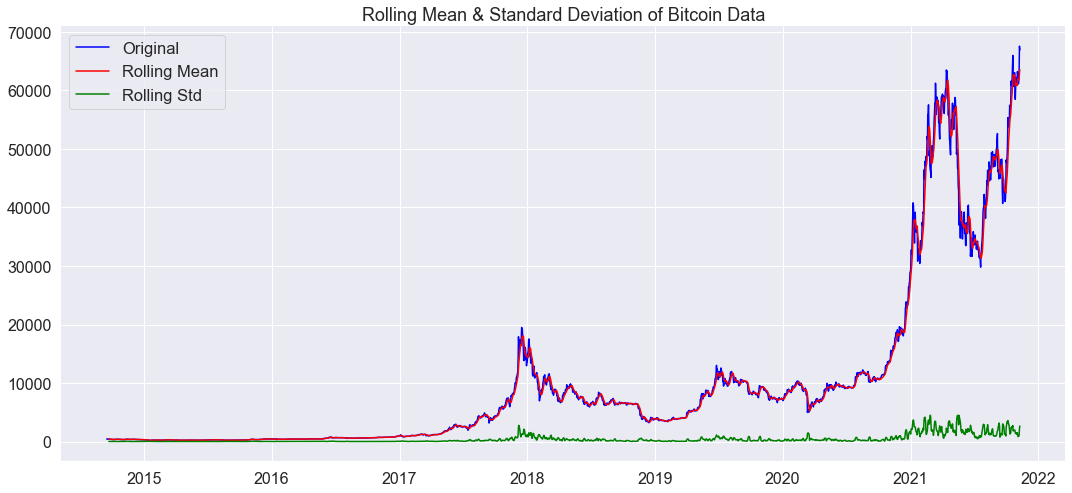

In [16]:
test_for_stationary(bitcoin_price, 'Bitcoin Data')

The null hypothesis for this test is that there is a unit root.

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

Results of Augmented Dickey-Fuller Test on Dogecoin Data
ADF Stastistic: -2.153679
p-value: 0.223485

The graph is non stationary! (It has a trend)

Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


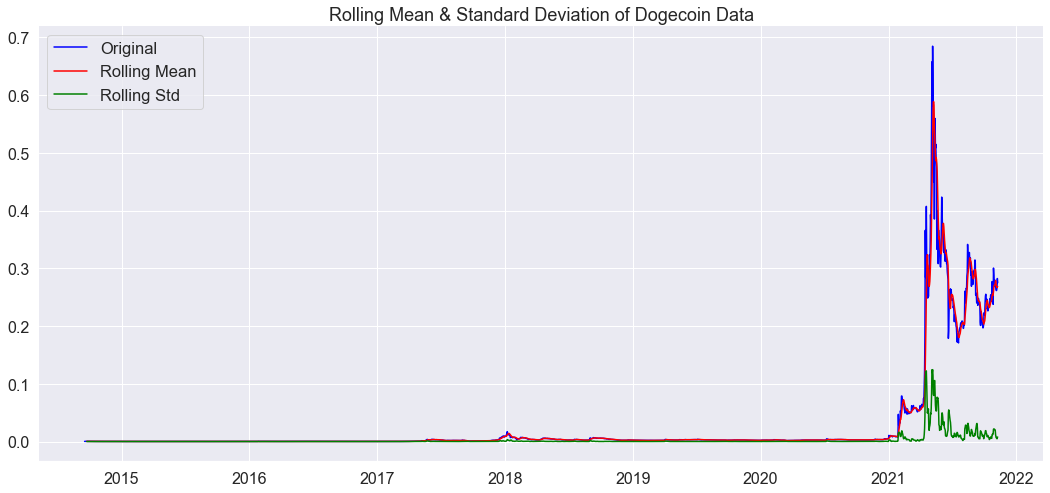

In [17]:
test_for_stationary(dogecoin_price, 'Dogecoin Data')

Results of Augmented Dickey-Fuller Test on Shiba-Inu Coin Data
ADF Stastistic: 3.149606
p-value: 1.000000

The graph is non stationary! (It has a trend)

Critical values:
	1%: -3.460 
	5%: -2.875 
	10%: -2.574 


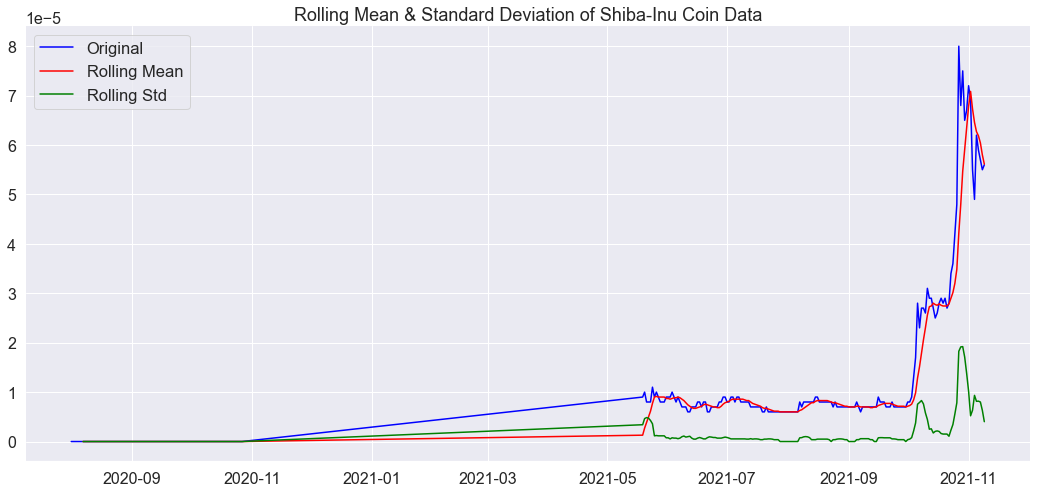

In [18]:
test_for_stationary(shibcoin_price, 'Shiba-Inu Coin Data')

The test statistic is very large compared to the critical value. The above series show that rolling mean value varies  with time and is not stationary. The series needs to be Stationarized. we need to eliminate the trend and seasonality from the series to make it stationary

## Section 3.2: From non-stationarity to stationarity
Now that we now our series has a trend, we need to remove it in order to proceed with the models.

Differencing is one way for converting the simplest non-stationary data to stationary data. This procedure entails calculating the differences between two successive observations. To achieve this, Pandas provides a diff function.

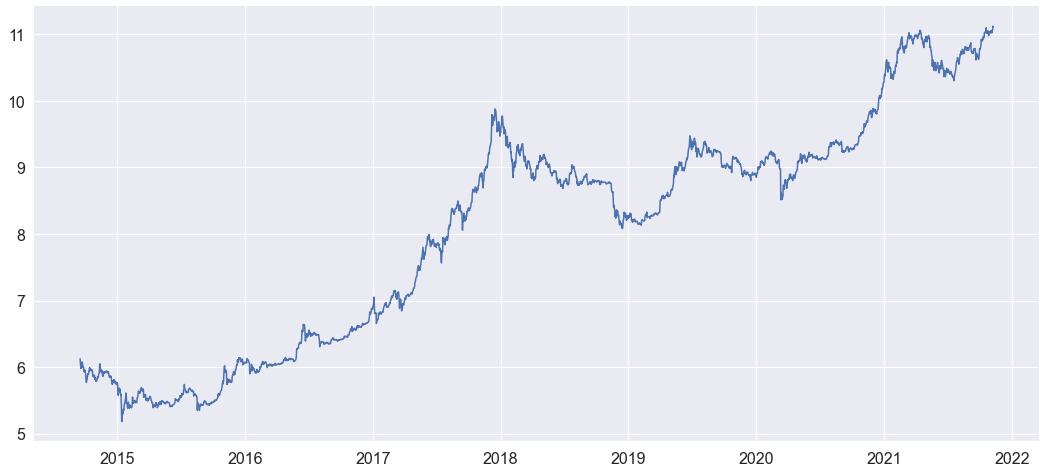

In [19]:
btc_logtransformed = np.log(bitcoin_price)
plt.plot(btc_logtransformed)

Results of Augmented Dickey-Fuller Test on Bitcoin Data after applying Stationarity Methods
ADF Stastistic: -7.723516
p-value: 0.000000

The graph is stationary! (It doesn't have a trend)

Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


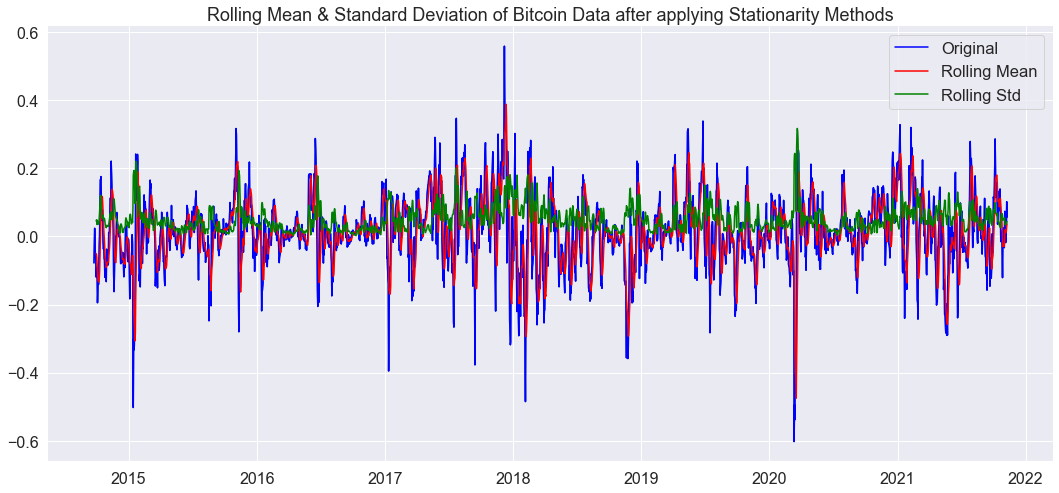

In [20]:
btc_diff_logtrans = btc_logtransformed - btc_logtransformed.shift(7)
plt.plot(btc_diff_logtrans)

btc_diff_logtrans.dropna(inplace=True)

test_for_stationary(btc_diff_logtrans, 'Bitcoin Data after applying Stationarity Methods')

The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.

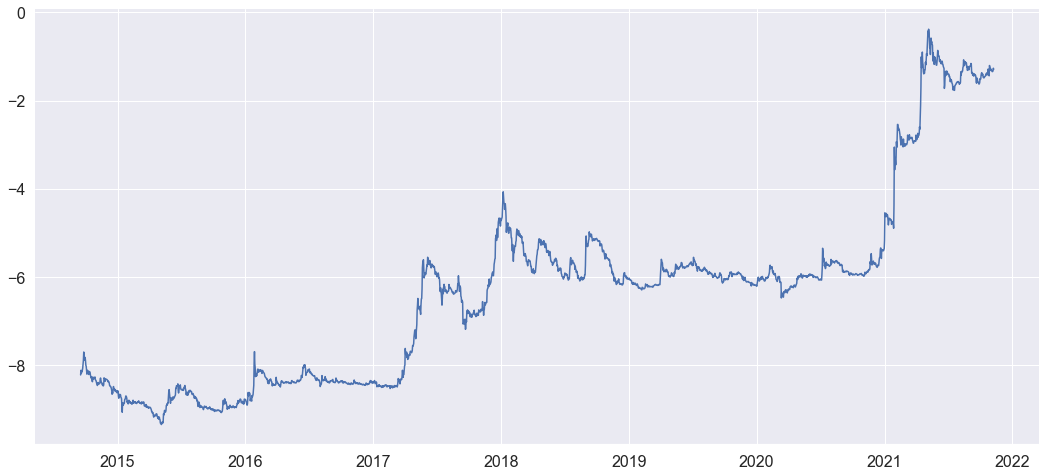

In [21]:
dgc_logtransformed = np.log(dogecoin_price)
plt.plot(dgc_logtransformed)

Results of Augmented Dickey-Fuller Test on Dogecoin Data after applying Stationarity Methods
ADF Stastistic: -7.286107
p-value: 0.000000

The graph is stationary! (It doesn't have a trend)

Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


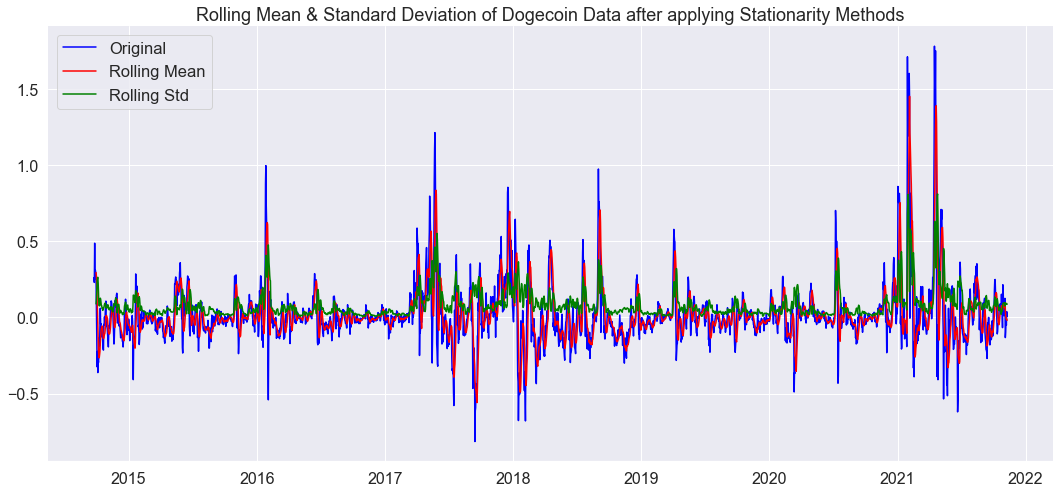

In [22]:
dgc_diff_logtrans = dgc_logtransformed - dgc_logtransformed.shift(7)

dgc_diff_logtrans.dropna(inplace=True)
test_for_stationary(dgc_diff_logtrans, 'Dogecoin Data after applying Stationarity Methods')

Results of Augmented Dickey-Fuller Test on Shiba-Inu coin Data after applying Stationarity Methods
ADF Stastistic: -4.198149
p-value: 0.000664

The graph is stationary! (It doesn't have a trend)

Critical values:
	1%: -3.606 
	5%: -2.937 
	10%: -2.607 


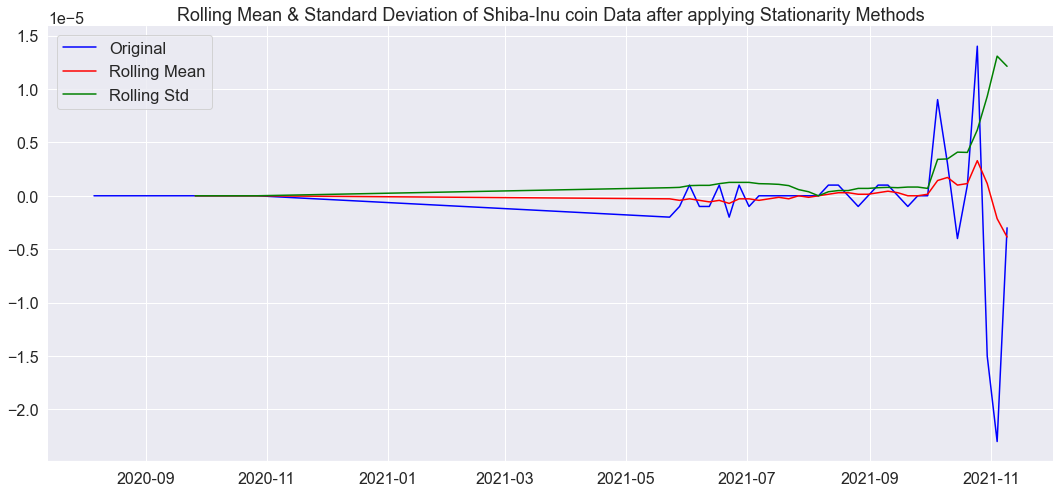

In [23]:
shibcoin["diff_1"] = shibcoin['Adj Close'].diff(periods=1)
shibcoin["diff_2"] = shibcoin['Adj Close'].diff(periods=2)
shibcoin["diff_3"] = shibcoin['Adj Close'].diff(periods=3)

shibcoin_stationarity_adjusted = pd.Series(shibcoin["diff_3"][::5]).dropna()
test_for_stationary(shibcoin_stationarity_adjusted, 'Shiba-Inu coin Data after applying Stationarity Methods')

# Price Prediction of Bitcoin, Dogecoin and Shiba-Inu Coin

### Price Prediction for Bitcoin using ARIMA

In [24]:
#ACF and PACF plots:
lag_acf = acf(btc_diff_logtrans, nlags=50, fft=False)
lag_pacf = pacf(btc_diff_logtrans, nlags=30, method='ols')

Text(0, 0.5, 'Correlation')

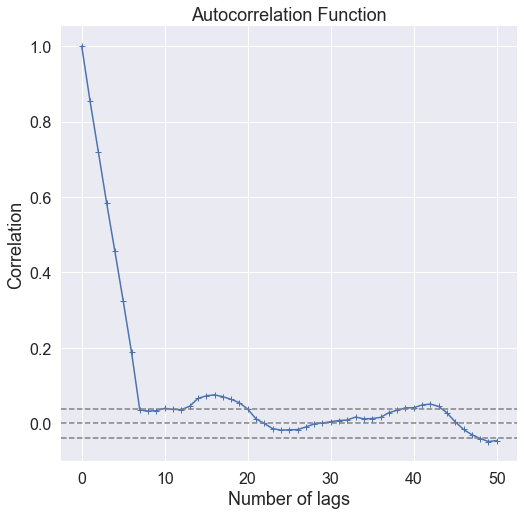

In [25]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf, marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('Correlation')

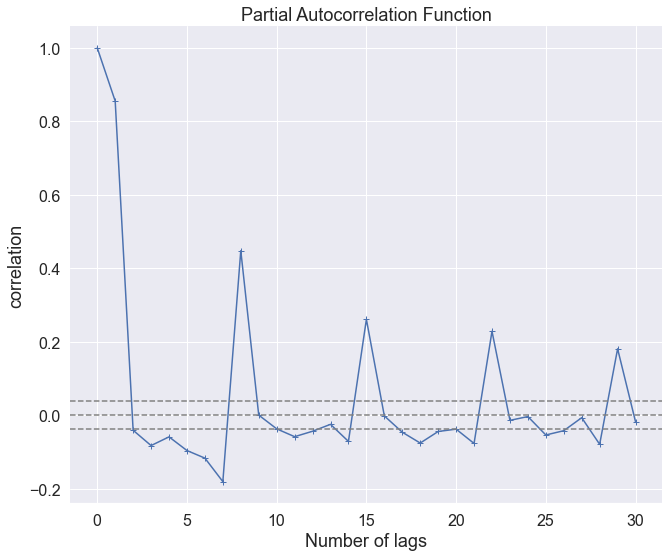

In [26]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf, marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

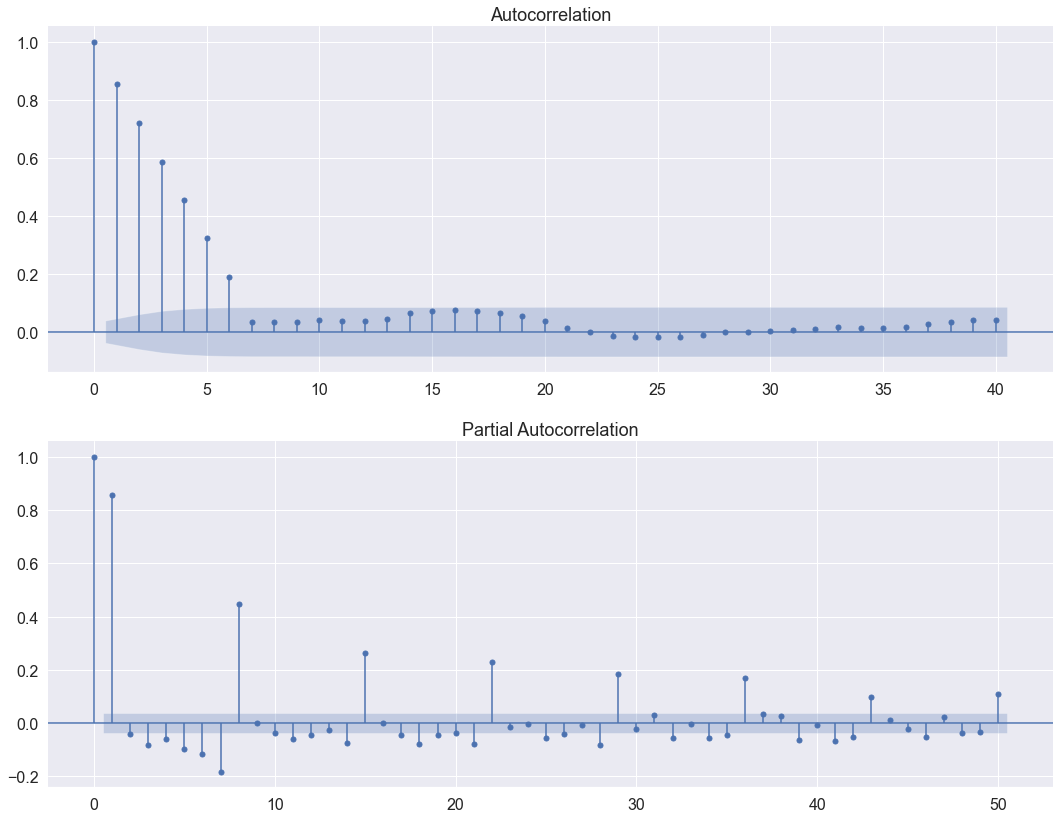

In [27]:
plt.figure(figsize=(18,14))
plt.subplot(211)
plot_acf(btc_diff_logtrans, ax=plt.gca(),lags=40)
plt.subplot(212)
plot_pacf(btc_diff_logtrans, ax=plt.gca(), lags=50)
plt.show()

Observations from the plots are listed below.

The confidence interevals are the two dotted lines on either side of 0 in this graph. The Lag values are detected using PACF and ACF plots for Autoregression(AR) and Moving Average(MA) parameters, p and q respectively, to calculate the 'p' and 'q' values.

p – The lag value at which the PACF chart first crosses the upper confidence interval. If you look attentively, you'll discover that p=2 in this situation. On day 2, the PACF exhibits a considerable lag.

q – The lag value at which the ACF chart first passes the upper confidence interval. If you look attentively, you'll find that q=6 in this example, because the ACF indicates a considerable lag for the 6th day.

### ARIMA Model

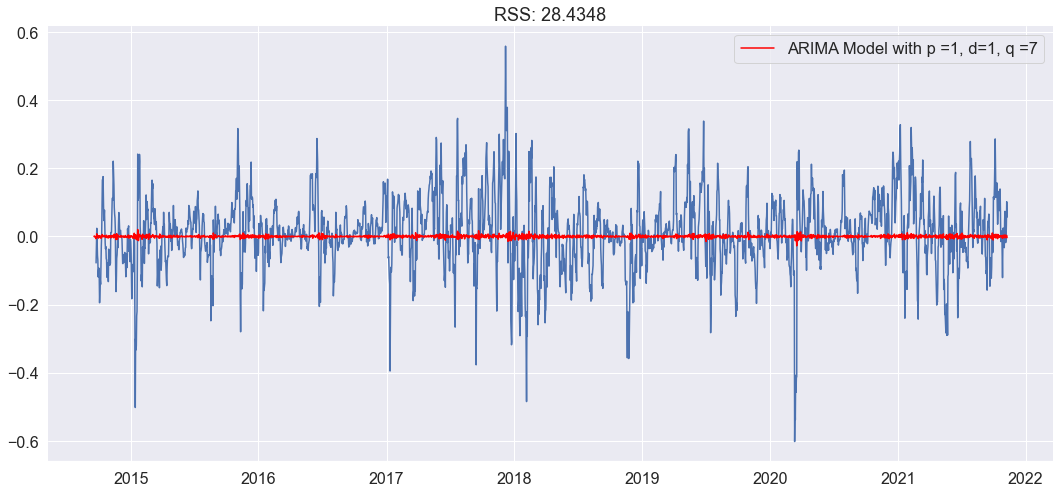

In [28]:
model = ARIMA(btc_logtransformed, order=(2,1,7))
results_ARIMA = model.fit(trend= 'nc', disp=-1)

plt.plot(btc_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label='ARIMA Model with p =1, d=1, q =7')

RSS = results_ARIMA.fittedvalues-btc_diff_logtrans
RSS.dropna(inplace=True)

plt.title('RSS: %.4f' % sum(RSS**2))
plt.legend(loc='best')

In [29]:
#model summary
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 2606
Model:                 ARIMA(2, 1, 7)   Log Likelihood                4735.537
Method:                       css-mle   S.D. of innovations              0.039
Date:                Mon, 22 Nov 2021   AIC                          -9451.074
Time:                        07:44:44   BIC                          -9392.418
Sample:                             1   HQIC                         -9429.824
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close     0.2878      0.200      1.442      0.149      -0.103       0.679
ar.L2.D.Adj Close    -0.6386      0.143     -4.470      0.000      -0.919      -0.359
ma.L1.D.Adj Close    -0.

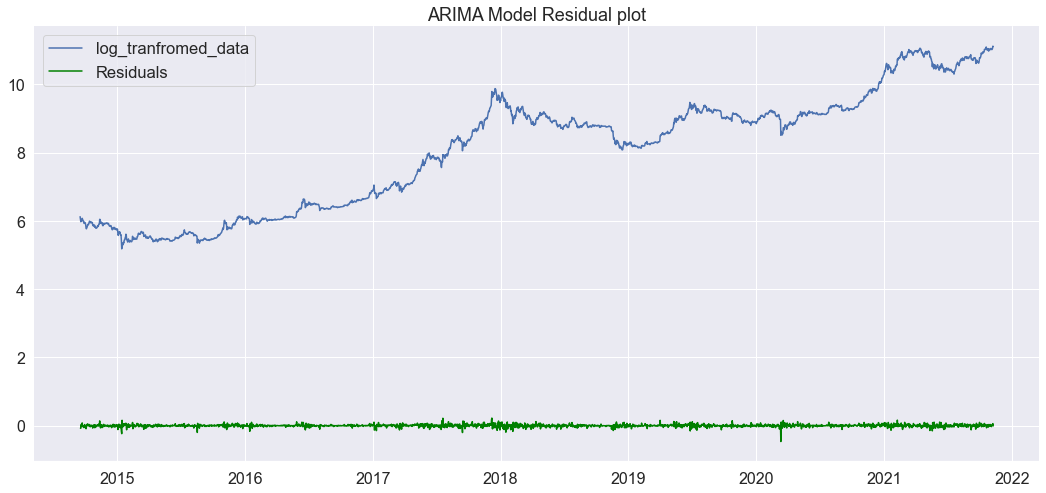

In [30]:
plt.plot(btc_logtransformed, label = 'log_tranfromed_data')
plt.plot(results_ARIMA.resid, color ='green',label= 'Residuals')
plt.title('ARIMA Model Residual plot')
plt.legend(loc = 'best')

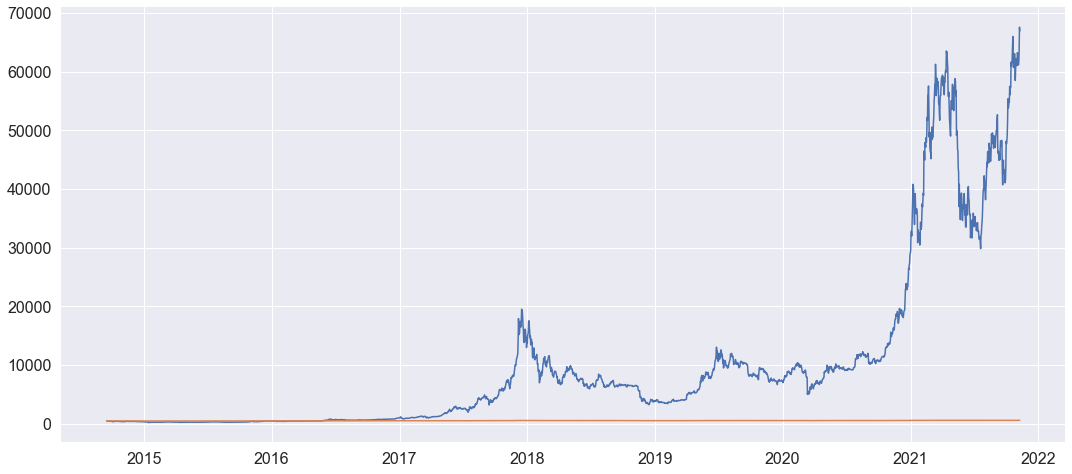

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pd.Series(btc_logtransformed.iloc[0], index=btc_logtransformed.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.plot(bitcoin_price)
plt.plot(predictions_ARIMA)

**Bitcoin Test Data**

In [32]:
btc_test_data = pd.read_csv("BTC-USD Test.csv", index_col= 'Date')
btc_test_data.index = pd.to_datetime(btc_test_data.index, format='%Y-%m-%d')
btc_test_data = btc_test_data['Adj Close']
btc_test_data

Date
2021-11-10    64995.230
2021-11-11    64949.961
2021-11-12    64155.941
2021-11-13    64469.527
2021-11-14    65466.840
2021-11-15    63557.871
2021-11-16    60161.246
Name: Adj Close, dtype: float64

In [33]:
dates = [pd.Timestamp('2021-11-10'), pd.Timestamp('2021-11-11'), pd.Timestamp('2021-11-12'), pd.Timestamp(
    '2021-11-13'), pd.Timestamp('2021-11-14'), pd.Timestamp('2021-11-15'), pd.Timestamp('2021-11-16')]

forecast = pd.Series(results_ARIMA.forecast(steps=7)[0], dates)
forecast = np.exp(forecast)
print(forecast)

error = mean_squared_error(btc_test_data, forecast)
print('Test MSE: %.3f' % error)

2021-11-10    66728.779
2021-11-11    66892.919
2021-11-12    67196.727
2021-11-13    67341.628
2021-11-14    67354.907
2021-11-15    67118.453
2021-11-16    67042.112
dtype: float64
Test MSE: 12552069.170


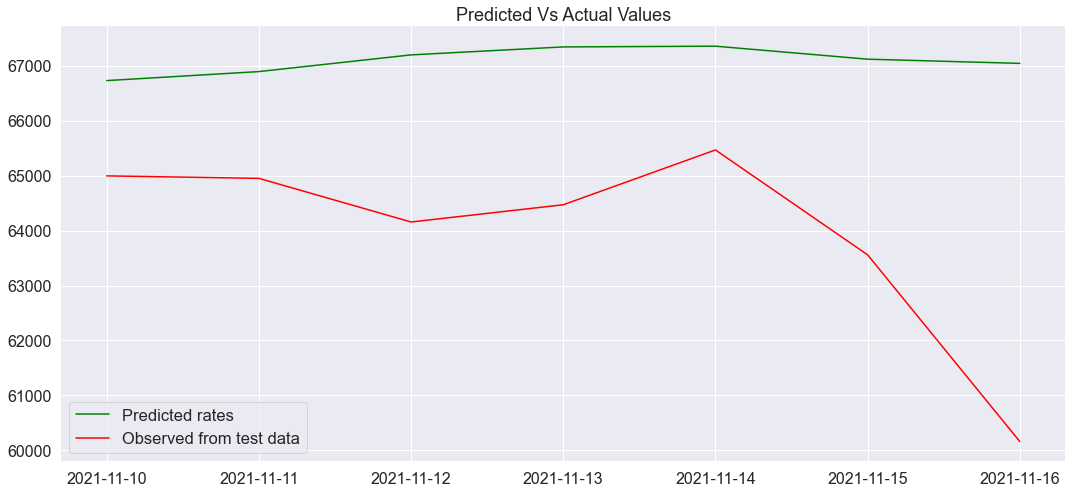

In [34]:
plt.plot(forecast, color ='green', label ='Predicted rates')
plt.plot(btc_test_data, color = 'red', label = 'Observed from test data')

plt.title('Predicted Vs Actual Values')
plt.legend(loc = 'best')

In [35]:
print ('The RMSE of the prediction is: ', round(mean_squared_error(btc_test_data, forecast, squared=False), 2))

The RMSE of the prediction is:  3542.89


## Price Prediction for Dogecoin using ARIMA

In [36]:
dgc_diff_logtrans = dgc_diff_logtrans.fillna(0)
dgc_logtransformed = dgc_logtransformed.fillna(0)

#ACF and PACF plots:
lag_acf = acf(dgc_diff_logtrans, nlags=50, fft=False)
lag_pacf = pacf(dgc_diff_logtrans, nlags=30, method='ols')

Text(0, 0.5, 'Correlation')

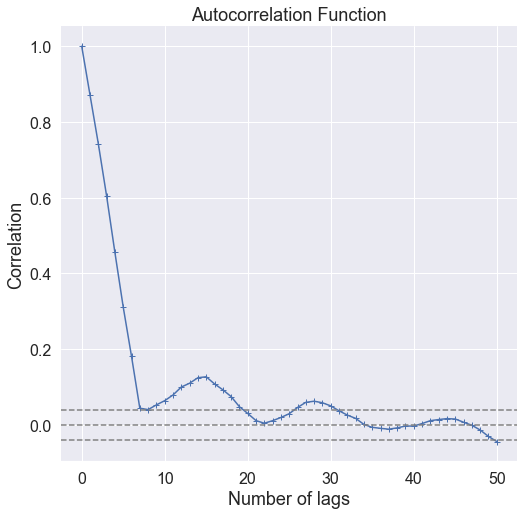

In [37]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf, marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('Correlation')

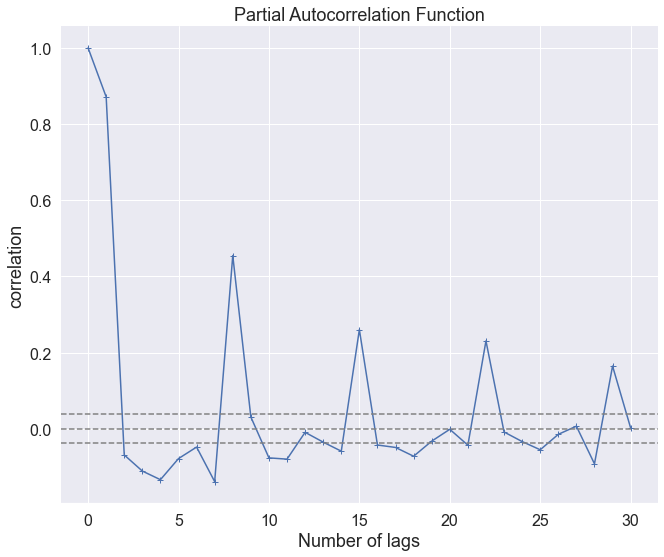

In [38]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf, marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

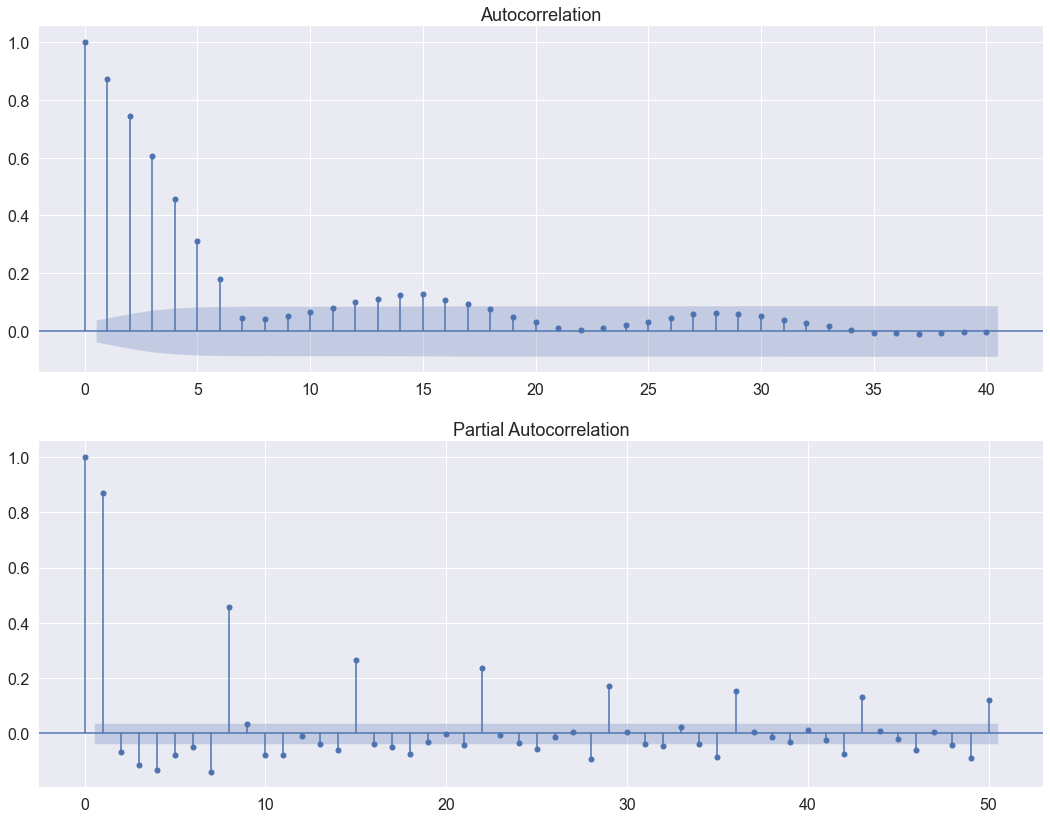

In [39]:
plt.figure(figsize=(18,14))
plt.subplot(211)
plot_acf(dgc_diff_logtrans, ax=plt.gca(),lags=40)
plt.subplot(212)
plot_pacf(dgc_diff_logtrans, ax=plt.gca(), lags=50)
plt.show()

Observations from the plots are listed below.

The confidence interevals are the two dotted lines on either side of 0 in this graph. The Lag values are detected using PACF and ACF plots for Autoregression(AR) and Moving Average(MA) parameters, p and q respectively, to calculate the 'p' and 'q' values.

p – The lag value at which the PACF chart first crosses the upper confidence interval. If you look attentively, you'll discover that p=2 in this situation. On day 2, the PACF exhibits a considerable lag.

q – The lag value at which the ACF chart first passes the upper confidence interval. If you look attentively, you'll find that q=6 in this example, because the ACF indicates a considerable lag for the 6th day.

### ARIMA Model

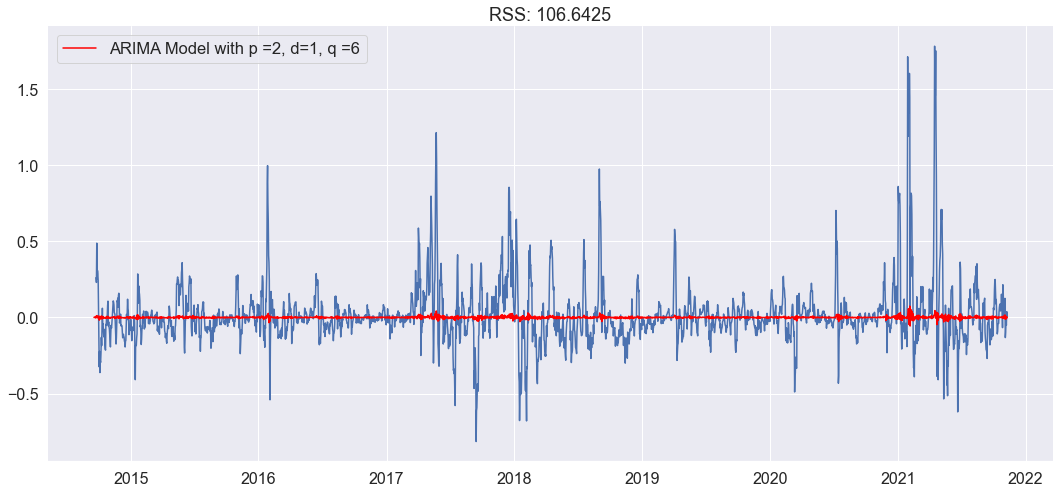

In [40]:
model = ARIMA(dgc_logtransformed, order=(2,1,6))
results_ARIMA = model.fit(trend= 'nc', disp=-1)

plt.plot(dgc_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label='ARIMA Model with p =2, d=1, q =6')

RSS = results_ARIMA.fittedvalues-dgc_diff_logtrans
RSS.dropna(inplace=True)

plt.title('RSS: %.4f' % sum(RSS**2))
plt.legend(loc='best')

In [41]:
#model summary
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 2606
Model:                 ARIMA(2, 1, 6)   Log Likelihood                3132.070
Method:                       css-mle   S.D. of innovations              0.073
Date:                Mon, 22 Nov 2021   AIC                          -6246.139
Time:                        07:44:52   BIC                          -6193.349
Sample:                             1   HQIC                         -6227.014
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close    -0.4645      0.176     -2.644      0.008      -0.809      -0.120
ar.L2.D.Adj Close    -0.6032      0.210     -2.877      0.004      -1.014      -0.192
ma.L1.D.Adj Close     0.

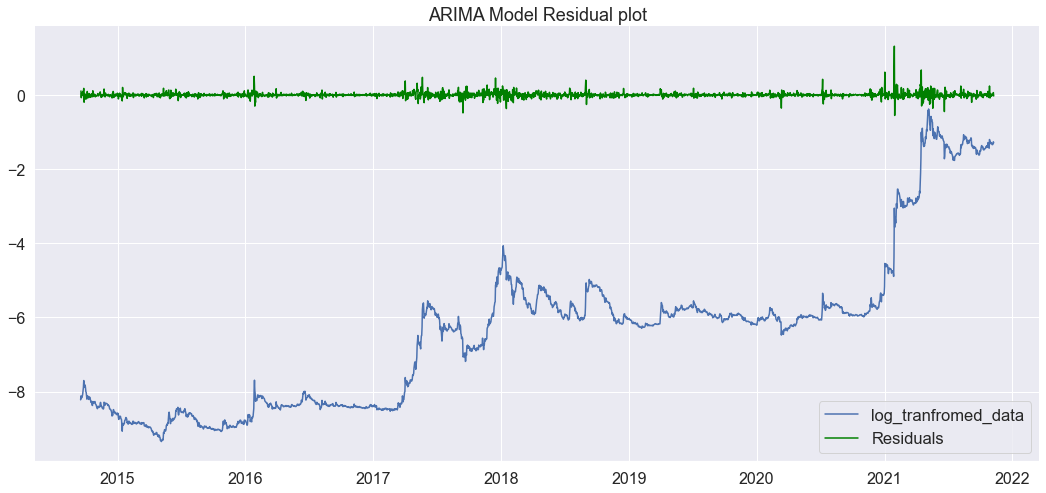

In [42]:
plt.plot(dgc_logtransformed, label = 'log_tranfromed_data')
plt.plot(results_ARIMA.resid, color ='green',label= 'Residuals')
plt.title('ARIMA Model Residual plot')
plt.legend(loc = 'best')

### Using ARIMA Model of forecast price of Dogecoin

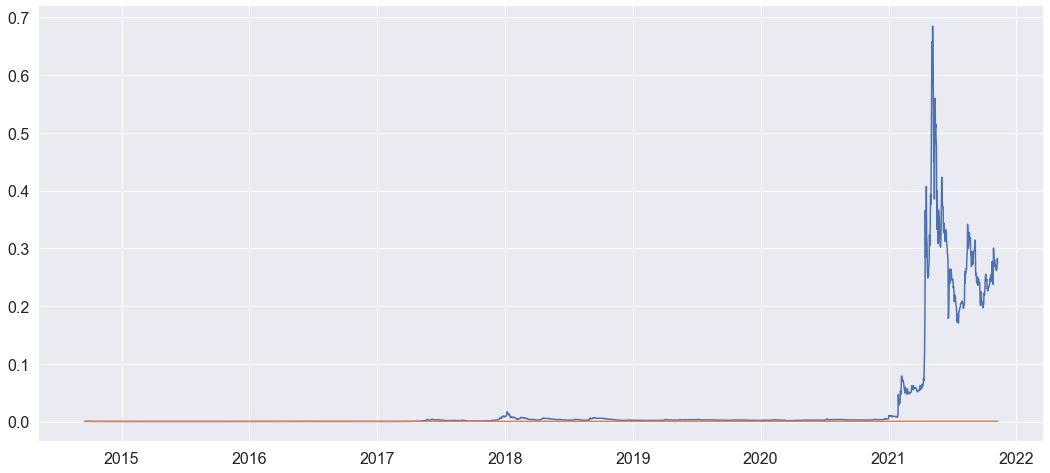

In [43]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pd.Series(dgc_logtransformed.iloc[0], index=dgc_logtransformed.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.plot(dogecoin_price)
plt.plot(predictions_ARIMA)

**Dogecoin Test Data**

In [44]:
doge_test_data = pd.read_csv("DOGE-USD Test.csv", index_col= 'Date')
doge_test_data.index = pd.to_datetime(doge_test_data.index, format='%Y-%m-%d')
doge_test_data = doge_test_data['Adj Close']
doge_test_data

Date
2021-11-10    0.256
2021-11-11    0.261
2021-11-12    0.259
2021-11-13    0.262
2021-11-14    0.263
2021-11-15    0.257
2021-11-16    0.237
Name: Adj Close, dtype: float64

In [45]:
dates = [pd.Timestamp('2021-11-10'), pd.Timestamp('2021-11-11'), pd.Timestamp('2021-11-12'), pd.Timestamp(
    '2021-11-13'), pd.Timestamp('2021-11-14'), pd.Timestamp('2021-11-15'), pd.Timestamp('2021-11-16')]

forecast = pd.Series(results_ARIMA.forecast(steps=7)[0], dates)
forecast = np.exp(forecast)
print(forecast)

error = mean_squared_error(doge_test_data, forecast)
print('Test MSE: %.3f' % error)

2021-11-10    0.276
2021-11-11    0.277
2021-11-12    0.276
2021-11-13    0.276
2021-11-14    0.277
2021-11-15    0.276
2021-11-16    0.276
dtype: float64
Test MSE: 0.000


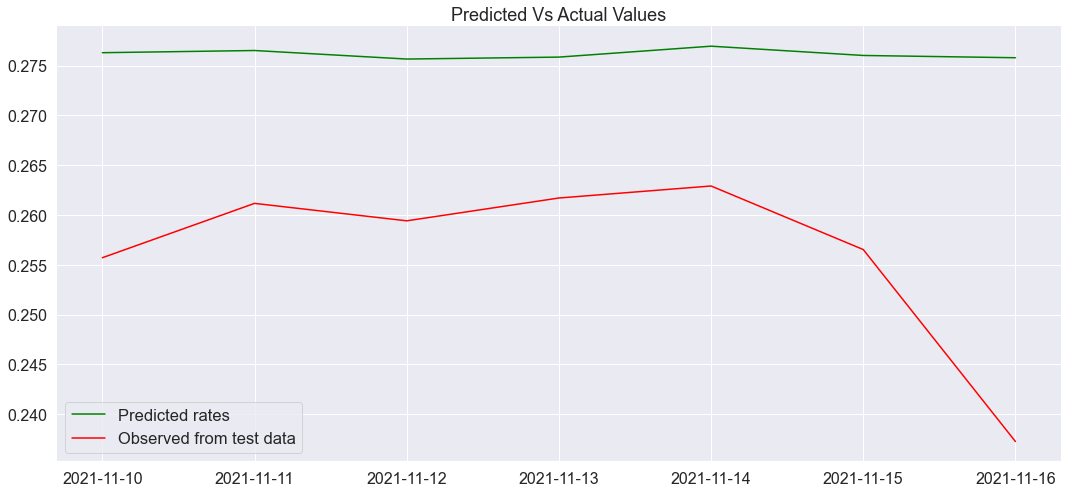

In [46]:
plt.plot(forecast, color ='green', label ='Predicted rates')
plt.plot(doge_test_data, color = 'red', label = 'Observed from test data')

plt.title('Predicted Vs Actual Values')
plt.legend(loc = 'best')

In [47]:
print ('The RMSE of the prediction is: ', round(mean_squared_error(doge_test_data, forecast, squared=False), 4))

The RMSE of the prediction is:  0.0213


## Price Prediction for Shiba-Inu Coin using ARIMA

In [48]:
#ACF and PACF plots:
lag_acf = acf(shibcoin_stationarity_adjusted, nlags=50, fft=False)
lag_pacf = pacf(shibcoin_stationarity_adjusted, nlags=20, method='ols')

Text(0, 0.5, 'Correlation')

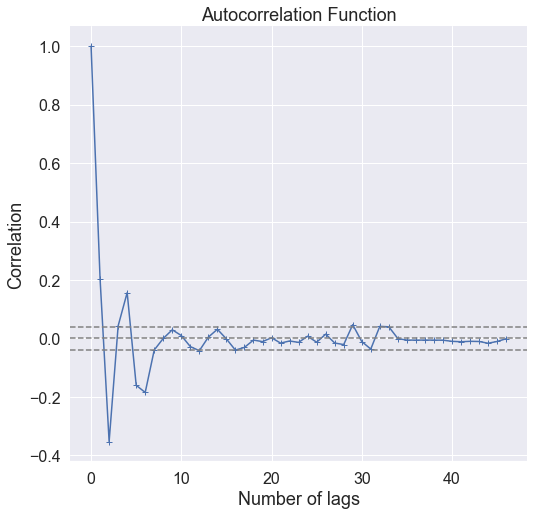

In [49]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf, marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('Correlation')

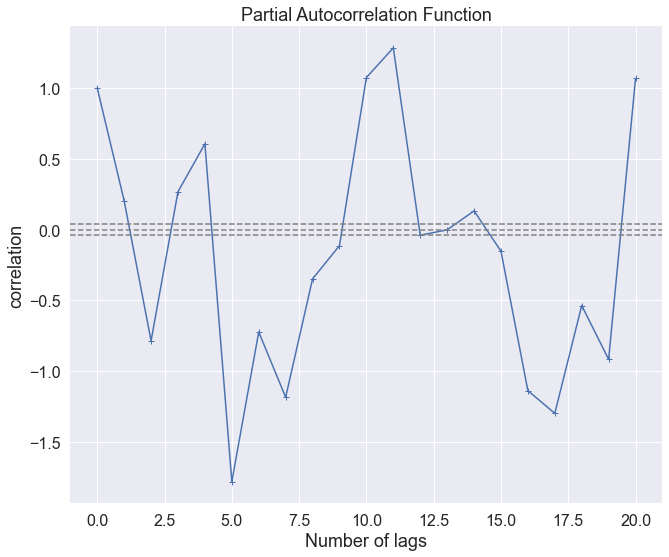

In [50]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf, marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(btc_diff_logtrans)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

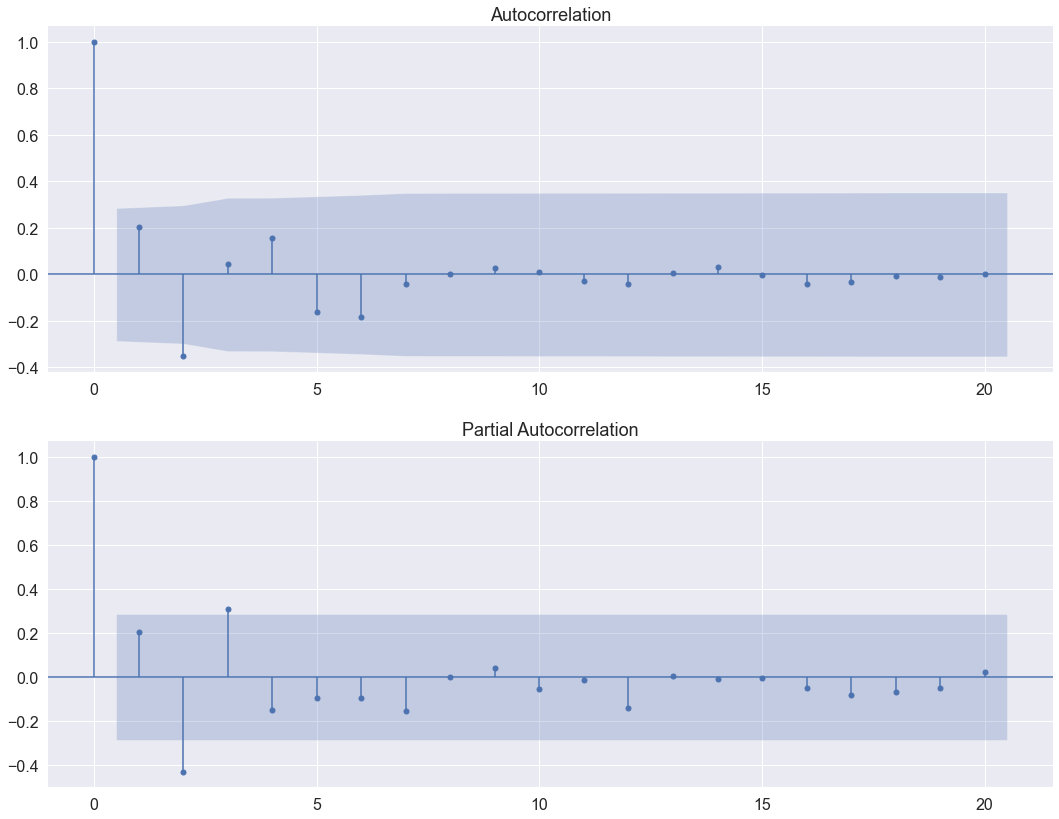

In [51]:
plt.figure(figsize=(18,14))
plt.subplot(211)
plot_acf(shibcoin_stationarity_adjusted, ax=plt.gca(),lags=20)
plt.subplot(212)
plot_pacf(shibcoin_stationarity_adjusted, ax=plt.gca(), lags=20)
plt.show()

Observations from the plots are listed below.

The confidence interevals are the two dotted lines on either side of 0 in this graph. The Lag values are detected using PACF and ACF plots for Autoregression(AR) and Moving Average(MA) parameters, p and q respectively, to calculate the 'p' and 'q' values.

p – The lag value at which the PACF chart first crosses the upper confidence interval. If you look attentively, you'll discover that p=1 in this situation. On day 2, the PACF exhibits a considerable lag.

q – The lag value at which the ACF chart first passes the upper confidence interval. If you look attentively, you'll find that q=1 in this example, because the ACF indicates a considerable lag for the 1st day.

### ARIMA Model

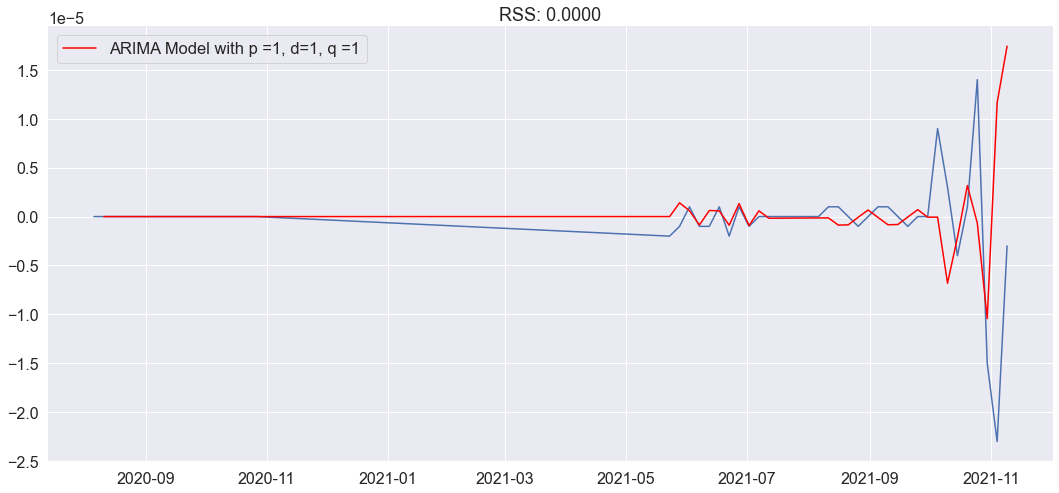

In [52]:
model = ARIMA(shibcoin_stationarity_adjusted, order=(1,1,1))
results_ARIMA = model.fit(trend= 'nc', disp=-1)

plt.plot(shibcoin_stationarity_adjusted)
plt.plot(results_ARIMA.fittedvalues, color='red', label='ARIMA Model with p =1, d=1, q =1')

RSS = results_ARIMA.fittedvalues-shibcoin_stationarity_adjusted
RSS.dropna(inplace=True)

plt.title('RSS: %.4f' % sum(RSS**2))
plt.legend(loc='best')

In [53]:
#model summary
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.diff_3   No. Observations:                   46
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 496.955
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 22 Nov 2021   AIC                           -987.910
Time:                        07:44:56   BIC                           -982.424
Sample:                             1   HQIC                          -985.855
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ar.L1.D.diff_3     0.2247      0.146      1.544      0.123      -0.061       0.510
ma.L1.D.diff_3    -1.0000      0.077    -12.956      0.000      -1.151      -0.849
                                    

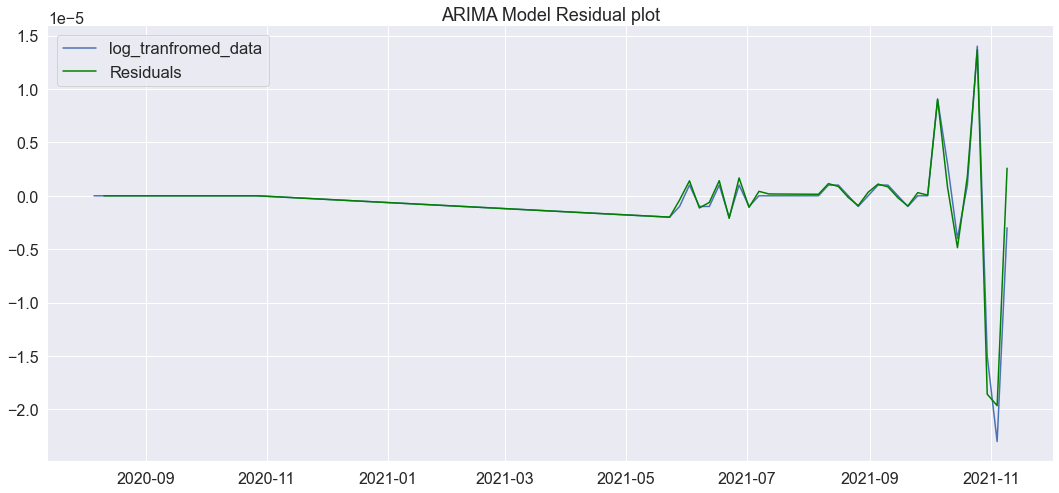

In [54]:
plt.plot(shibcoin_stationarity_adjusted, label = 'log_tranfromed_data')
plt.plot(results_ARIMA.resid, color ='green',label= 'Residuals')
plt.title('ARIMA Model Residual plot')
plt.legend(loc = 'best')

### Using ARIMA Model of forecast price of Shiba-Inu Coins

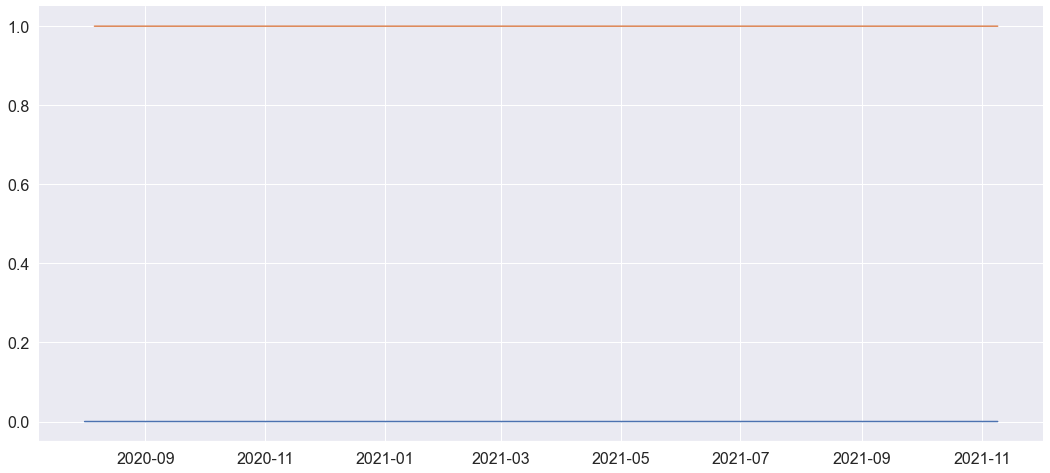

In [55]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pd.Series(shibcoin_stationarity_adjusted.iloc[0], index=shibcoin_stationarity_adjusted.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.plot(shibcoin_price)
plt.plot(predictions_ARIMA)

**Shiba-Inu Coin Test Data**

In [56]:
shib_test_data = pd.read_csv("SHIB-USD Test.csv", index_col= 'Date')
shib_test_data.index = pd.to_datetime(shib_test_data.index, format='%Y-%m-%d')
shib_test_data = shib_test_data['Adj Close']
shib_test_data

Date
2021-11-10    5.000e-05
2021-11-11    5.700e-05
2021-11-12    5.200e-05
2021-11-13    5.200e-05
2021-11-14    5.300e-05
2021-11-15    5.300e-05
2021-11-16    4.800e-05
Name: Adj Close, dtype: float64

In [57]:
dates = [pd.Timestamp('2021-11-10'), pd.Timestamp('2021-11-11'), pd.Timestamp('2021-11-12'), pd.Timestamp(
    '2021-11-13'), pd.Timestamp('2021-11-14'), pd.Timestamp('2021-11-15'), pd.Timestamp('2021-11-16')]

forecast = pd.Series(results_ARIMA.forecast(steps=7)[0], dates)
forecast = np.exp(forecast)
print(forecast)

error = mean_squared_error(doge_test_data, forecast)
print('Test MSE: %.3f' % error)

2021-11-10    1.0
2021-11-11    1.0
2021-11-12    1.0
2021-11-13    1.0
2021-11-14    1.0
2021-11-15    1.0
2021-11-16    1.0
dtype: float64
Test MSE: 0.553


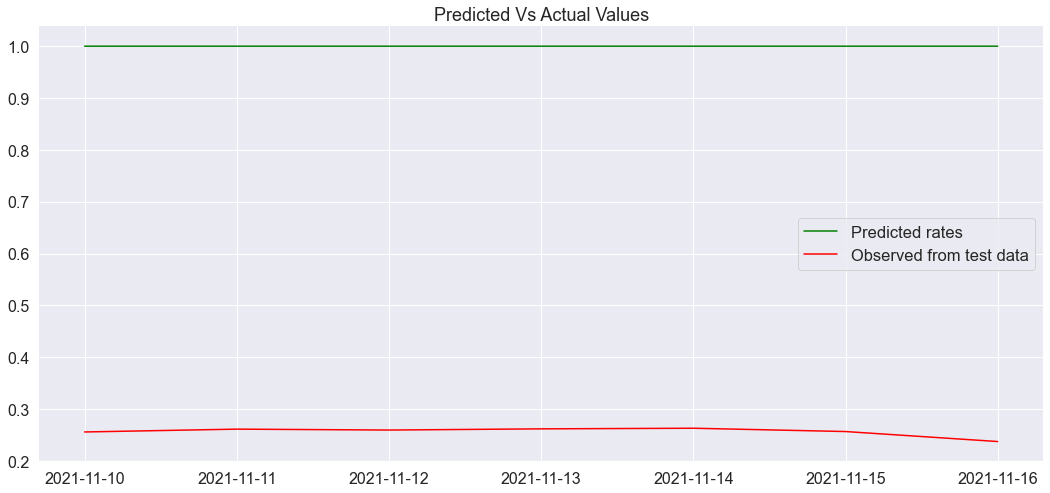

In [58]:
plt.plot(forecast, color ='green', label ='Predicted rates')
plt.plot(doge_test_data, color = 'red', label = 'Observed from test data')
plt.title('Predicted Vs Actual Values')
plt.legend(loc = 'best')

In [59]:
print ('The RMSE of the prediction is: ', mean_squared_error(shib_test_data, forecast, squared=False))

The RMSE of the prediction is:  0.9999472252818681


# Cryptocurrency Price Prediction using FB Prophet

## Bitcoin Price Prediction using FB Prophet

### Data Preparation

In [60]:
btc_prophet = bitcoin['Adj Close'].copy()
btc_prophet = pd.DataFrame(btc_prophet)
btc_prophet.reset_index(drop=False, inplace=True)
btc_prophet.columns =['ds','y']
btc_prophet

,ds,y
0,2014-09-17,457.334
1,2014-09-18,424.440
2,2014-09-19,394.796
3,2014-09-20,408.904
4,2014-09-21,398.821
...,...,...
2602,2021-11-05,61125.676
2603,2021-11-06,61527.480
2604,2021-11-07,63326.988
2605,2021-11-08,67566.828


### Modeling and Forecasting

In [61]:
m = Prophet.Prophet(daily_seasonality=True)
m.fit(btc_prophet)

In [62]:
future = m.make_future_dataframe(periods= 7, freq='D')
forecast = m.predict(future)
forecast.tail(7)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2607,2021-11-10,59432.288,52568.394,63859.458,59432.288,59432.288,-1301.261,-1301.261,-1301.261,-251.839,...,-11.667,-11.667,-11.667,-1037.755,-1037.755,-1037.755,0.0,0.0,0.0,58131.027
2608,2021-11-11,59529.557,53015.360,63939.596,59529.557,59529.557,-1373.110,-1373.110,-1373.110,-251.839,...,-42.295,-42.295,-42.295,-1078.977,-1078.977,-1078.977,0.0,0.0,0.0,58156.447
2609,2021-11-12,59626.826,52575.910,63883.859,59626.826,59626.826,-1328.597,-1328.597,-1328.597,-251.839,...,37.940,37.940,37.940,-1114.698,-1114.698,-1114.698,0.0,0.0,0.0,58298.229
2610,2021-11-13,59724.094,52414.734,63894.708,59724.094,59724.094,-1381.511,-1381.511,-1381.511,-251.839,...,14.722,14.722,14.722,-1144.394,-1144.394,-1144.394,0.0,0.0,0.0,58342.584
2611,2021-11-14,59821.363,52594.488,63971.165,59821.363,59821.363,-1432.371,-1432.371,-1432.371,-251.839,...,-12.847,-12.847,-12.847,-1167.686,-1167.686,-1167.686,0.0,0.0,0.0,58388.992
2612,2021-11-15,59918.632,53360.436,64089.538,59918.632,59918.632,-1412.078,-1412.078,-1412.078,-251.839,...,24.110,24.110,24.110,-1184.348,-1184.348,-1184.348,0.0,0.0,0.0,58506.554
2613,2021-11-16,60015.900,52638.187,64166.006,60015.900,60015.900,-1456.110,-1456.110,-1456.110,-251.839,...,-9.964,-9.964,-9.964,-1194.308,-1194.308,-1194.308,0.0,0.0,0.0,58559.790


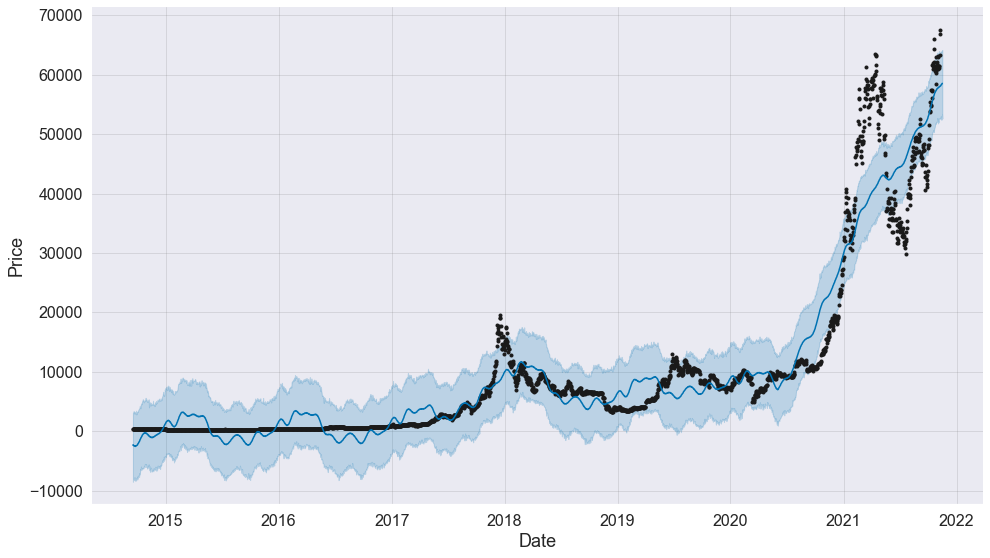

In [63]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price', figsize=(14,8))

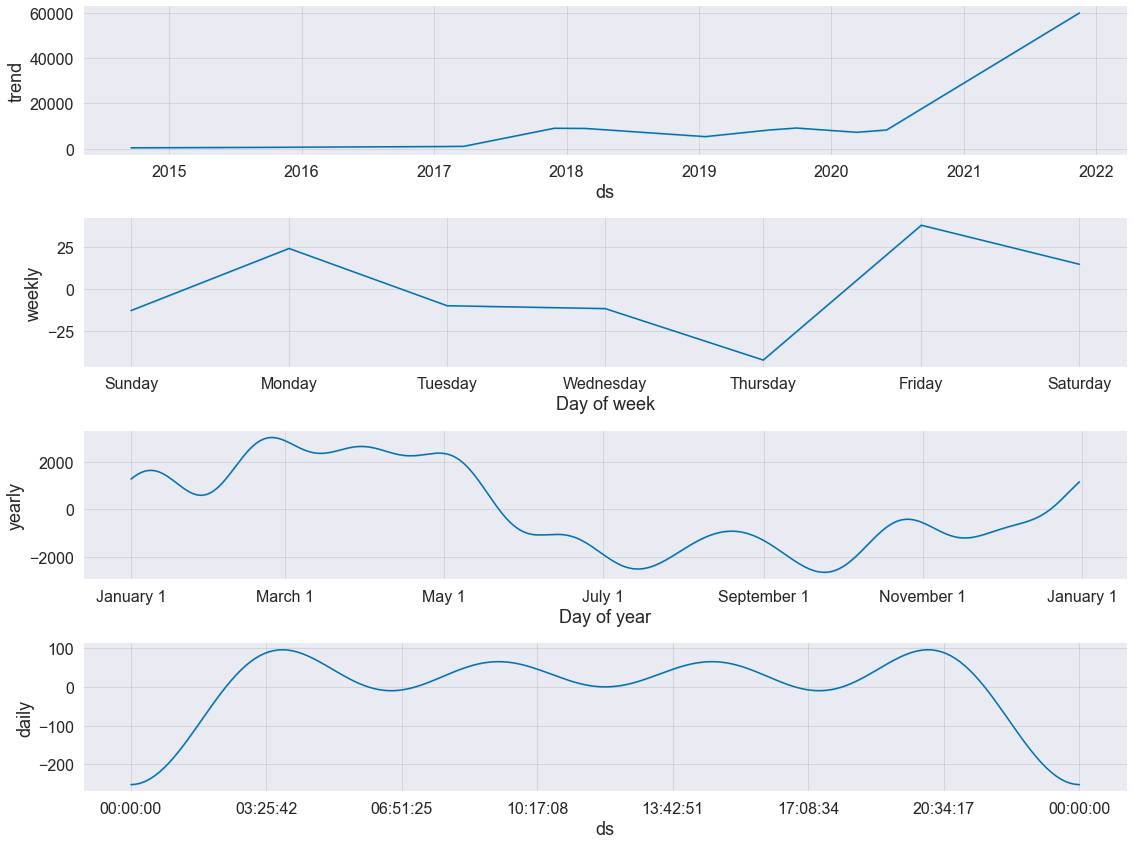

In [64]:
figure2 = m.plot_components(forecast, figsize=(16,12))

In [65]:
forecasted_values = forecast[['ds', 'yhat']].tail(7)
forecasted_values = forecasted_values.set_index('ds')
forecasted_values.columns = ['y']
forecasted_values

,y
ds,
2021-11-10,58131.027
2021-11-11,58156.447
2021-11-12,58298.229
2021-11-13,58342.584
2021-11-14,58388.992
2021-11-15,58506.554
2021-11-16,58559.790


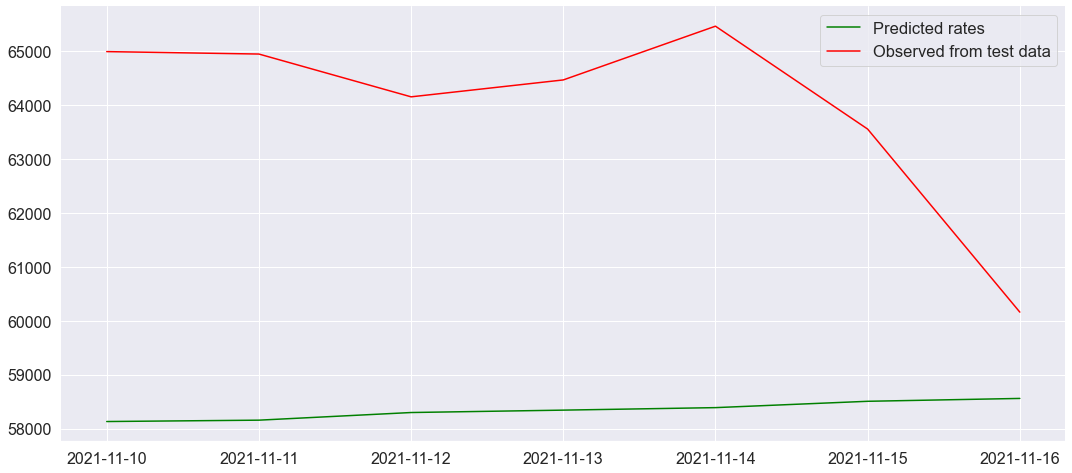

In [66]:
plt.plot(forecasted_values.y, color ='green', label ='Predicted rates')
plt.plot(btc_test_data, color = 'red', label = 'Observed from test data')
plt.legend(loc = 'best')

In [67]:
print ('The RMSE of the prediction is: ', round(mean_squared_error(btc_test_data, forecasted_values.y, squared=False), 2))

The RMSE of the prediction is:  5895.49


## Dogecoin Price Prediction using FB Prophet

### Data Preparation

In [68]:
dgc_prophet = dogecoin['Adj Close'].copy()
dgc_prophet = pd.DataFrame(dgc_prophet)
dgc_prophet.reset_index(drop=False, inplace=True)
dgc_prophet.columns =['ds','y']
dgc_prophet

,ds,y
0,2014-09-17,2.680e-04
1,2014-09-18,2.980e-04
2,2014-09-19,2.770e-04
3,2014-09-20,2.920e-04
4,2014-09-21,2.880e-04
...,...,...
2602,2021-11-05,2.615e-01
2603,2021-11-06,2.619e-01
2604,2021-11-07,2.663e-01
2605,2021-11-08,2.824e-01


## Modeling and Forecasting

In [69]:
m = Prophet.Prophet(daily_seasonality=True)
m.fit(dgc_prophet)

In [70]:
future = m.make_future_dataframe(periods= 7, freq='D')
forecast = m.predict(future)
forecast.tail(7)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2607,2021-11-10,0.293,0.243,0.343,0.293,0.293,-0.004,-0.004,-0.004,0.007,...,-2.720e-04,-2.720e-04,-2.720e-04,-0.011,-0.011,-0.011,0.0,0.0,0.0,0.289
2608,2021-11-11,0.294,0.239,0.342,0.294,0.294,-0.004,-0.004,-0.004,0.007,...,-1.978e-04,-1.978e-04,-1.978e-04,-0.011,-0.011,-0.011,0.0,0.0,0.0,0.290
2609,2021-11-12,0.294,0.240,0.342,0.294,0.294,-0.003,-0.003,-0.003,0.007,...,5.788e-04,5.788e-04,5.788e-04,-0.011,-0.011,-0.011,0.0,0.0,0.0,0.291
2610,2021-11-13,0.295,0.242,0.341,0.295,0.295,-0.003,-0.003,-0.003,0.007,...,2.321e-04,2.321e-04,2.321e-04,-0.011,-0.011,-0.011,0.0,0.0,0.0,0.292
2611,2021-11-14,0.296,0.243,0.343,0.296,0.296,-0.003,-0.003,-0.003,0.007,...,1.739e-04,1.739e-04,1.739e-04,-0.011,-0.011,-0.011,0.0,0.0,0.0,0.292
2612,2021-11-15,0.296,0.242,0.343,0.296,0.296,-0.004,-0.004,-0.004,0.007,...,-1.358e-04,-1.358e-04,-1.358e-04,-0.011,-0.011,-0.011,0.0,0.0,0.0,0.293
2613,2021-11-16,0.297,0.242,0.341,0.297,0.297,-0.004,-0.004,-0.004,0.007,...,-3.792e-04,-3.792e-04,-3.792e-04,-0.011,-0.011,-0.011,0.0,0.0,0.0,0.293


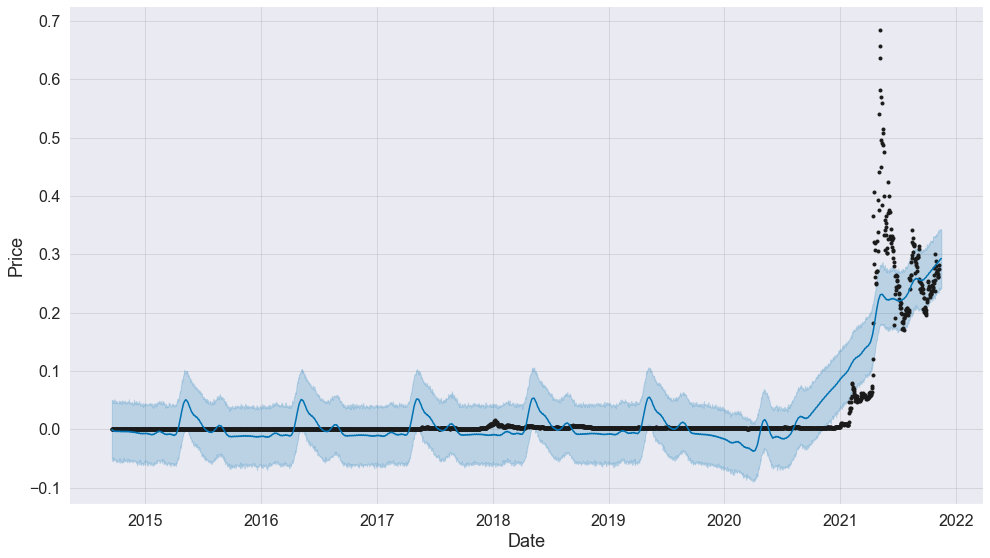

In [71]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price', figsize=(14,8))

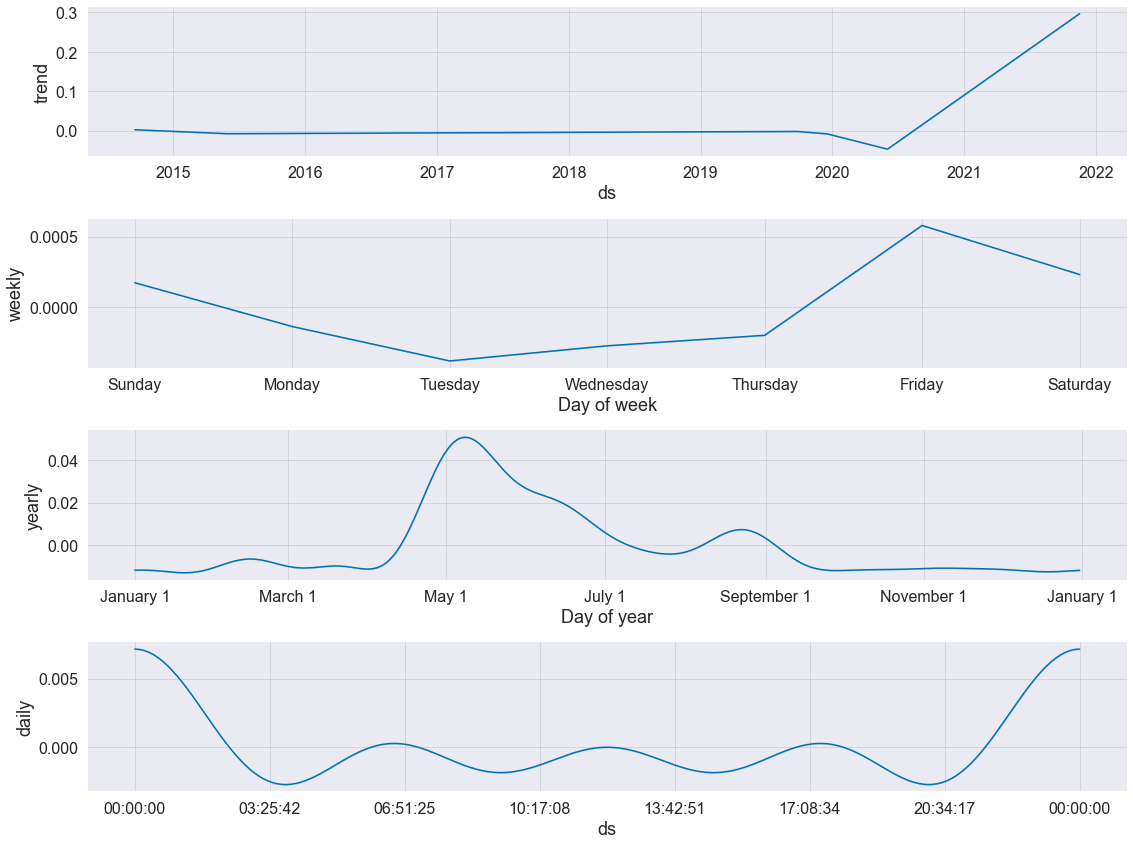

In [72]:
figure2 = m.plot_components(forecast, figsize=(16,12))

In [73]:
forecasted_values = forecast[['ds', 'yhat']].tail(7)
forecasted_values = forecasted_values.set_index('ds')
forecasted_values.columns = ['y']
forecasted_values

,y
ds,
2021-11-10,0.289
2021-11-11,0.290
2021-11-12,0.291
2021-11-13,0.292
2021-11-14,0.292
2021-11-15,0.293
2021-11-16,0.293


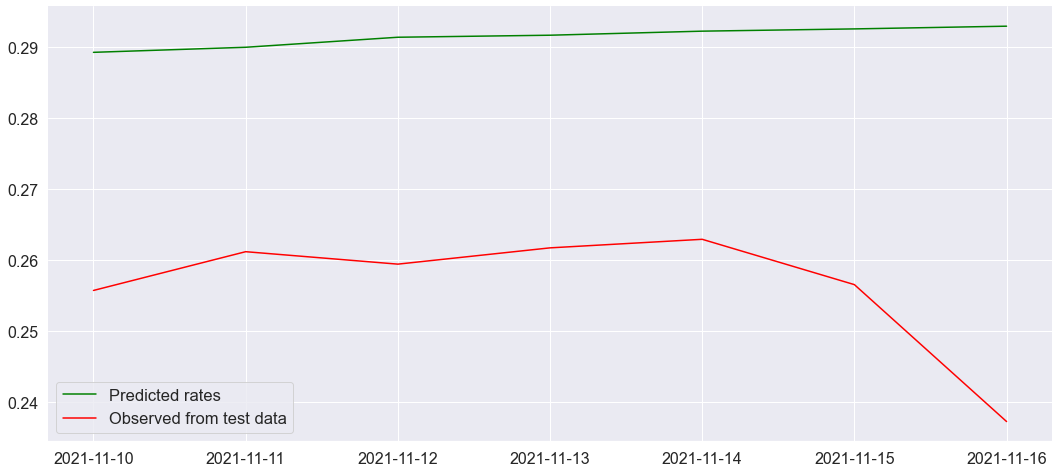

In [74]:
plt.plot(forecasted_values.y, color ='green', label ='Predicted rates')
plt.plot(doge_test_data, color = 'red', label = 'Observed from test data')
plt.legend(loc = 'best')

In [75]:
print ('The RMSE of the prediction is: ', round(mean_squared_error(doge_test_data, forecasted_values.y, squared=False), 4))

The RMSE of the prediction is:  0.0361


## Shiba-Inu Coin Price Prediction using FB Prophet

### Data Preparation

In [76]:
shib_prophet = shibcoin['Adj Close'].copy()
shib_prophet = pd.DataFrame(shib_prophet)
shib_prophet.reset_index(drop=False, inplace=True)
shib_prophet.columns =['ds','y']
shib_prophet

,ds,y
0,2020-08-01,0.000e+00
1,2020-08-02,0.000e+00
2,2020-08-03,0.000e+00
3,2020-08-04,0.000e+00
4,2020-08-05,0.000e+00
...,...,...
231,2021-11-05,6.200e-05
232,2021-11-06,5.900e-05
233,2021-11-07,5.700e-05
234,2021-11-08,5.500e-05


## Modeling and Forecasting

In [77]:
m = Prophet.Prophet(daily_seasonality=True, yearly_seasonality=True)
m.fit(shib_prophet)

In [78]:
future = m.make_future_dataframe(periods= 7, freq='D')
forecast = m.predict(future)
forecast.tail (7)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
236,2021-11-10,3.247e-05,3.972e-05,5.139e-05,3.247e-05,3.247e-05,1.319e-05,1.319e-05,1.319e-05,-4.598e-06,...,1.024e-06,1.024e-06,1.024e-06,1.676e-05,1.676e-05,1.676e-05,0.0,0.0,0.0,4.565e-05
237,2021-11-11,3.278e-05,3.114e-05,4.321e-05,3.278e-05,3.278e-05,4.391e-06,4.391e-06,4.391e-06,-4.598e-06,...,-3.516e-08,-3.516e-08,-3.516e-08,9.024e-06,9.024e-06,9.024e-06,0.0,0.0,0.0,3.717e-05
238,2021-11-12,3.310e-05,2.262e-05,3.466e-05,3.310e-05,3.310e-05,-4.409e-06,-4.409e-06,-4.409e-06,-4.598e-06,...,9.180e-08,9.180e-08,9.180e-08,9.749e-08,9.749e-08,9.749e-08,0.0,0.0,0.0,2.869e-05
239,2021-11-13,3.341e-05,1.297e-05,2.453e-05,3.341e-05,3.341e-05,-1.497e-05,-1.497e-05,-1.497e-05,-4.598e-06,...,-4.047e-07,-4.047e-07,-4.047e-07,-9.971e-06,-9.971e-06,-9.971e-06,0.0,0.0,0.0,1.844e-05
240,2021-11-14,3.373e-05,1.424e-06,1.401e-05,3.373e-05,3.374e-05,-2.611e-05,-2.611e-05,-2.611e-05,-4.598e-06,...,-4.065e-07,-4.065e-07,-4.065e-07,-2.111e-05,-2.111e-05,-2.111e-05,0.0,0.0,0.0,7.620e-06
241,2021-11-15,3.405e-05,-1.003e-05,2.090e-06,3.404e-05,3.406e-05,-3.796e-05,-3.796e-05,-3.796e-05,-4.598e-06,...,-1.598e-07,-1.598e-07,-1.598e-07,-3.320e-05,-3.320e-05,-3.320e-05,0.0,0.0,0.0,-3.915e-06
242,2021-11-16,3.436e-05,-2.259e-05,-1.012e-05,3.435e-05,3.438e-05,-5.084e-05,-5.084e-05,-5.084e-05,-4.598e-06,...,-1.096e-07,-1.096e-07,-1.096e-07,-4.613e-05,-4.613e-05,-4.613e-05,0.0,0.0,0.0,-1.648e-05


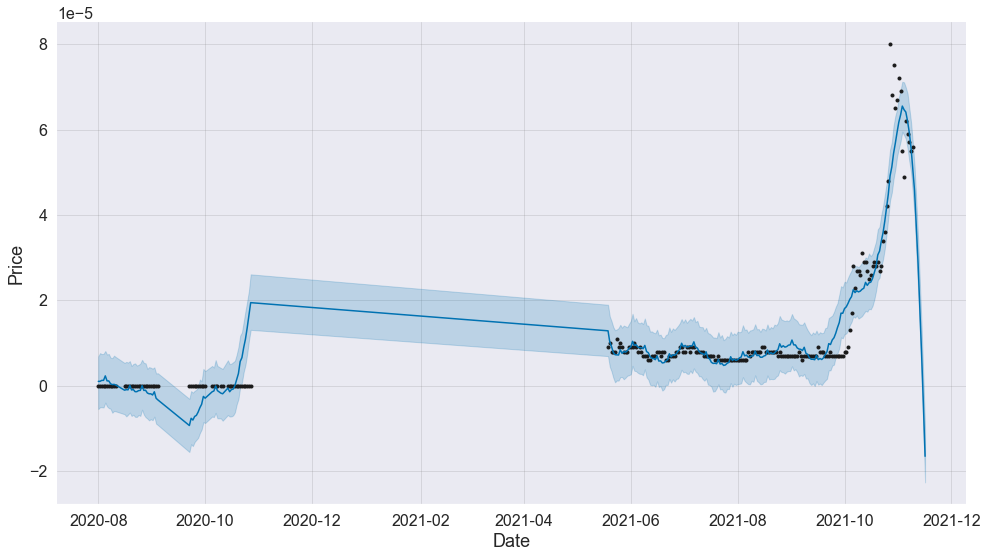

In [79]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price', figsize=(14,8))

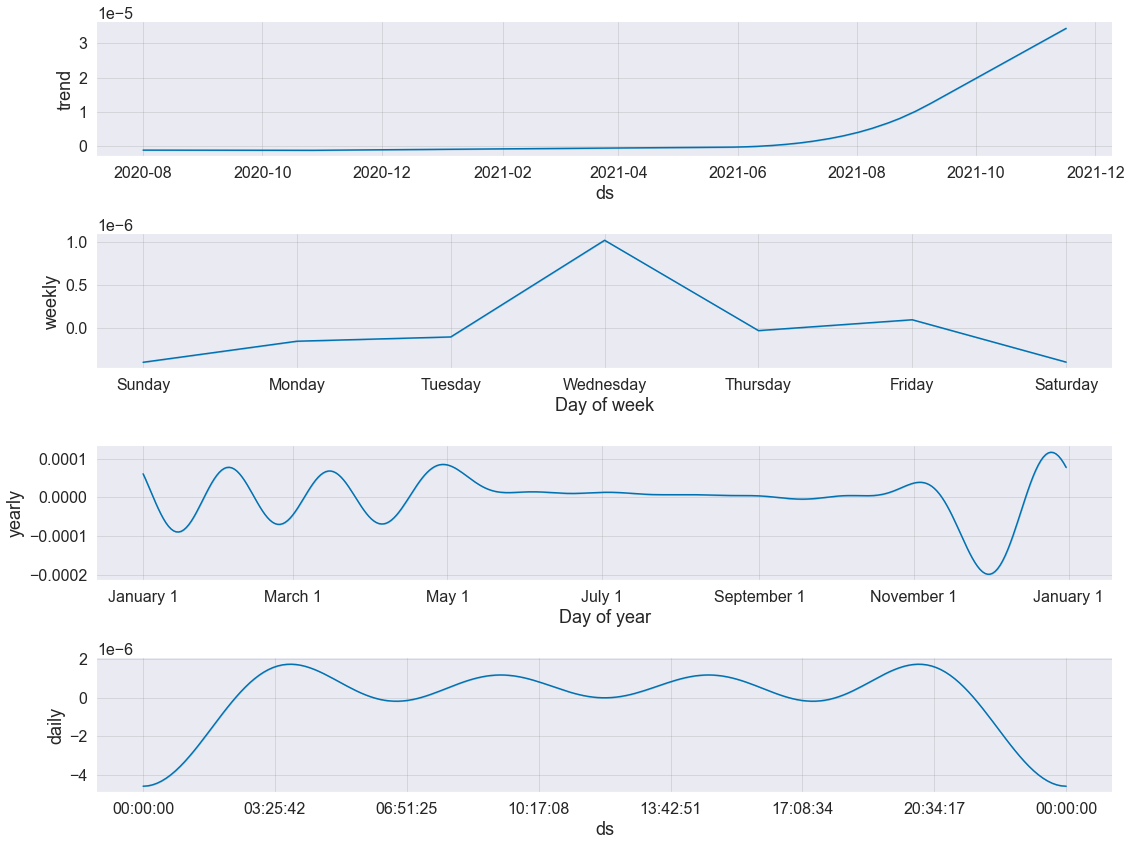

In [80]:
figure2 = m.plot_components(forecast, figsize=(16,12))

In [81]:
forecasted_values = forecast[['ds', 'yhat']].tail(7)
forecasted_values = forecasted_values.set_index('ds')
forecasted_values.columns = ['y']
forecasted_values

,y
ds,
2021-11-10,4.565e-05
2021-11-11,3.717e-05
2021-11-12,2.869e-05
2021-11-13,1.844e-05
2021-11-14,7.620e-06
2021-11-15,-3.915e-06
2021-11-16,-1.648e-05


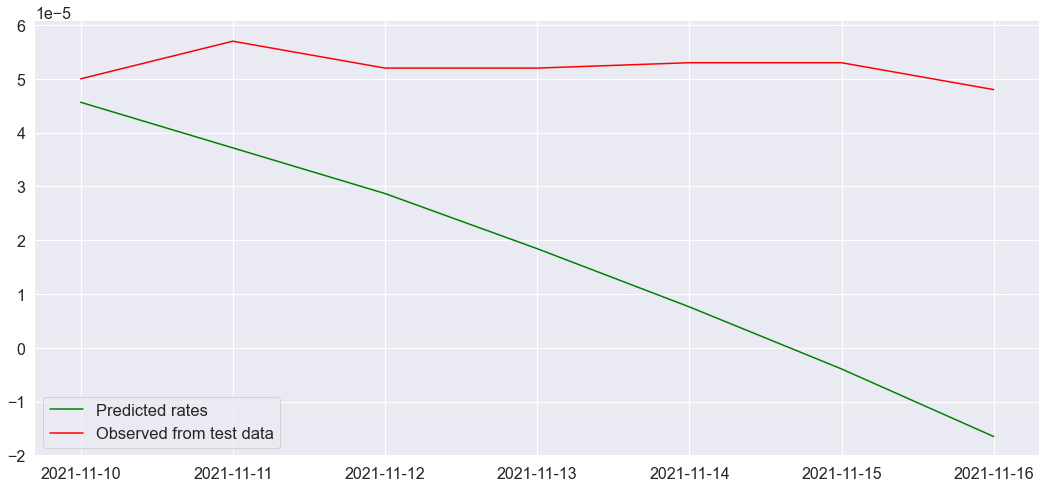

In [82]:
plt.plot(forecasted_values.y, color ='green', label ='Predicted rates')
plt.plot(shib_test_data, color = 'red', label = 'Observed from test data')
plt.legend(loc = 'best')

In [83]:
print ('The RMSE of the prediction is: ', round(mean_squared_error(doge_test_data, forecasted_values.y, squared=False), 4))

The RMSE of the prediction is:  0.2565
